In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
BASE_DIR = "C:/Users/BITS/Documents/"
RESULTS_DIR = os.path.join(BASE_DIR, "BRCA-preprocessed/MOFA-20 results/")
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots/")

# --- Input File Paths ---
LATENT_FACTORS_FILE = os.path.join(BASE_DIR, "latent_factors.csv")
CLINICAL_DATA_FILE = os.path.join(BASE_DIR, "clinical_20factor.csv")
MRNA_WEIGHTS_FILE = os.path.join(BASE_DIR, "mRNA_feature_loadings.csv")
MIRNA_WEIGHTS_FILE = os.path.join(BASE_DIR, "miRNA_feature_loadings.csv")
CNV_WEIGHTS_FILE = os.path.join(BASE_DIR, "CNV_feature_loadings.csv")
METHYL_WEIGHTS_FILE = os.path.join(BASE_DIR, "methylation_feature_loadings.csv")
PROTEIN_WEIGHTS_FILE = os.path.join(BASE_DIR, "protein_feature_loadings.csv")

# --- It's good practice to ensure output directories exist ---
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# --- Load all data files ---
print("Loading data files...")
try:
    latent_factors = pd.read_csv(LATENT_FACTORS_FILE)
    clinical_data = pd.read_csv(CLINICAL_DATA_FILE)
    mrna_weights = pd.read_csv(MRNA_WEIGHTS_FILE)
    mirna_weights = pd.read_csv(MIRNA_WEIGHTS_FILE)
    cnv_weights = pd.read_csv(CNV_WEIGHTS_FILE)
    methyl_weights = pd.read_csv(METHYL_WEIGHTS_FILE)
    protein_weights = pd.read_csv(PROTEIN_WEIGHTS_FILE)
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Could not load data file. {e}")
    print("Please ensure all file paths are correct before running again.")
    # Exit the script if files aren't found, as per user request
    exit()


Loading data files...
All data files loaded successfully.


In [5]:
clinical_data.head()

Unnamed: 0  X        sample_id ajcc_pathologic_stage          sample_type  \
0           1  1  TCGA-3C-AALI-01             Stage IIB  Primary solid Tumor   
1           2  2  TCGA-3C-AALK-01              Stage IA  Primary solid Tumor   
2           3  3  TCGA-4H-AAAK-01            Stage IIIA  Primary solid Tumor   
3           4  4  TCGA-5L-AAT1-01              Stage IV  Primary solid Tumor   
4           5  5  TCGA-5T-A9QA-01             Stage IIA  Primary solid Tumor   

  stage_classification  
0          Early Stage  
1          Early Stage  
2           Late Stage  
3           Late Stage  
4          Early Stage

In [4]:
latent_factors.head()

Unnamed: 0   Factor1   Factor2   Factor3   Factor4   Factor5  \
0  TCGA-3C-AALI-01  0.639902  0.892471 -0.410834 -0.913015 -3.555564   
1  TCGA-3C-AALK-01 -1.520547 -1.149389  0.427363  2.090040 -0.112681   
2  TCGA-4H-AAAK-01 -1.504596 -1.953555  1.890563 -1.399030 -1.060023   
3  TCGA-5L-AAT1-01 -1.665115 -1.034575 -2.492642  0.202116  0.290123   
4  TCGA-5T-A9QA-01 -0.489632  2.771917  1.532430  5.981275  0.892094   

    Factor6   Factor7   Factor8   Factor9  ...  Factor11  Factor12  Factor13  \
0  2.330874 -0.473768  0.679849 -0.025081  ...  1.081197 -0.623573  4.013067   
1  1.488944  0.677706  0.363164  0.326483  ...  0.443409  0.586862  0.849359   
2  0.805667 -0.634161  0.119660  0.689531  ... -0.472393  0.740484 -2.122864   
3  2.388590  0.171250 -0.459557 -0.097197  ...  0.331531  0.500514 -0.989911   
4  3.101825  0.072496  4.082042 -0.529657  ... -0.181365 -1.791988  2.203700   

   Factor14  Factor15  Factor16  Factor17  Factor18  Factor19  Factor20  
0 -0.591733 -0.789991 -0.108841 -0.750198  0.222287 -0.218786 -0.158664  
1  0.105145 -0.122614  0.038364 -0.084066  0.667773  0.577942  0.426919  
2  0.898425 -0.003302  0.071248 -1.458245  0.075260 -0.384082 -0.241443  
3  0.197287 -0.438626  0.105102 -1.641748  0.448908  0.615082  0.104172  
4  0.853620 -2.019944  0.082770 -2.088034 -0.157782 -0.488078  0.178300  

[5 rows x 21 columns]

In [6]:
latent_factors.rename(columns={'Unnamed: 0': 'SampleID'}, inplace=True)

In [7]:
clinical_data.drop(columns=['Unnamed: 0', 'X'], inplace=True)
clinical_data.head()
clinical_data.rename(columns={'sample_id': 'SampleID'}, inplace=True)

In [8]:
latent_factors.head()

SampleID   Factor1   Factor2   Factor3   Factor4   Factor5  \
0  TCGA-3C-AALI-01  0.639902  0.892471 -0.410834 -0.913015 -3.555564   
1  TCGA-3C-AALK-01 -1.520547 -1.149389  0.427363  2.090040 -0.112681   
2  TCGA-4H-AAAK-01 -1.504596 -1.953555  1.890563 -1.399030 -1.060023   
3  TCGA-5L-AAT1-01 -1.665115 -1.034575 -2.492642  0.202116  0.290123   
4  TCGA-5T-A9QA-01 -0.489632  2.771917  1.532430  5.981275  0.892094   

    Factor6   Factor7   Factor8   Factor9  ...  Factor11  Factor12  Factor13  \
0  2.330874 -0.473768  0.679849 -0.025081  ...  1.081197 -0.623573  4.013067   
1  1.488944  0.677706  0.363164  0.326483  ...  0.443409  0.586862  0.849359   
2  0.805667 -0.634161  0.119660  0.689531  ... -0.472393  0.740484 -2.122864   
3  2.388590  0.171250 -0.459557 -0.097197  ...  0.331531  0.500514 -0.989911   
4  3.101825  0.072496  4.082042 -0.529657  ... -0.181365 -1.791988  2.203700   

   Factor14  Factor15  Factor16  Factor17  Factor18  Factor19  Factor20  
0 -0.591733 -0.789991 -0.108841 -0.750198  0.222287 -0.218786 -0.158664  
1  0.105145 -0.122614  0.038364 -0.084066  0.667773  0.577942  0.426919  
2  0.898425 -0.003302  0.071248 -1.458245  0.075260 -0.384082 -0.241443  
3  0.197287 -0.438626  0.105102 -1.641748  0.448908  0.615082  0.104172  
4  0.853620 -2.019944  0.082770 -2.088034 -0.157782 -0.488078  0.178300  

[5 rows x 21 columns]

In [9]:
latent_factors = pd.merge(latent_factors, clinical_data, on='SampleID', how='inner')

In [10]:
!pip install statsmodels
!pip install pingouin
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
import pandas as pd
from scipy.stats import ttest_ind

PART 2: STATISTICAL ANALYSIS

In [11]:
latent_factors_columns = [col for col in latent_factors.columns if col.startswith('Factor')]

# --- 1. ANOVA Test ---
print("\n--- Performing ANOVA Test ---")
anova_results = {}
for factor in latent_factors_columns:
    groups = [latent_factors[latent_factors['stage_classification'] == stage][factor]
              for stage in latent_factors['stage_classification'].unique()]
    f_value, p_value = stats.f_oneway(*groups)
    anova_results[factor] = {'F-value': f_value, 'p-value': p_value}

anova_df = pd.DataFrame(anova_results).T
significant_anova = anova_df[anova_df['p-value'] < 0.05]
print("ANOVA results:")
print(anova_df)
print("\nSignificant Latent Factors (ANOVA):")
print(significant_anova)
anova_df.to_csv(os.path.join(RESULTS_DIR, "anova_results.csv"), index=True)
significant_anova.to_csv(os.path.join(RESULTS_DIR, "significant_anova_results.csv"), index=True)

# --- 2. Kruskal-Wallis Test ---
print("\n--- Performing Kruskal-Wallis Test ---")
kruskal_results = {}
for factor in latent_factors_columns:
    groups = [latent_factors[latent_factors['stage_classification'] == stage][factor]
              for stage in latent_factors['stage_classification'].unique()]
    h_stat, p_value = stats.kruskal(*groups)
    kruskal_results[factor] = {'H-statistic': h_stat, 'p-value': p_value}

kruskal_df = pd.DataFrame(kruskal_results).T
significant_kruskal = kruskal_df[kruskal_df['p-value'] < 0.05]
print("Kruskal-Wallis results:")
print(kruskal_df)
print("\nSignificant Latent Factors (Kruskal-Wallis):")
print(significant_kruskal)
kruskal_df.to_csv(os.path.join(RESULTS_DIR, "kruskal_results.csv"), index=True)
significant_kruskal.to_csv(os.path.join(RESULTS_DIR, "significant_kruskal_results.csv"), index=True)

# --- 3. Tukey's HSD Post-Hoc Test ---
print("\n--- Performing Tukey's HSD Post-Hoc Test ---")
# Note: This will be based on factors significant in the Kruskal-Wallis test
# and will overwrite the previously saved file, matching the original script's logic.
tukey_results = []
for factor in significant_kruskal.index:
    tukey = pairwise_tukeyhsd(endog=latent_factors[factor],
                              groups=latent_factors['stage_classification'],
                              alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_df['Factor'] = factor
    tukey_results.append(tukey_df)

if tukey_results:
    all_tukey_results = pd.concat(tukey_results, ignore_index=True)
    all_tukey_results.to_csv(os.path.join(RESULTS_DIR, "tukey_hsd_results.csv"), index=False)
    print("Tukey's HSD results saved.")
else:
    print("No significant factors for Tukey's HSD test.")

# --- 4. Welch's t-test ---
print("\n--- Performing Pairwise Welch's t-test ---")
stages = latent_factors['stage_classification'].unique()
all_welch_results = []
for factor in latent_factors_columns:
    for i in range(len(stages)):
        for j in range(i + 1, len(stages)):
            stage1, stage2 = stages[i], stages[j]
            group1 = latent_factors[latent_factors['stage_classification'] == stage1][factor]
            group2 = latent_factors[latent_factors['stage_classification'] == stage2][factor]
            t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
            all_welch_results.append({
                'Factor': factor, 'Group1': stage1, 'Group2': stage2,
                't-stat': t_stat, 'p-value': p_value
            })

welch_results_df = pd.DataFrame(all_welch_results)
significant_welch_results = welch_results_df[welch_results_df['p-value'] < 0.05]
print("Significant Welch's t-test results (p-value < 0.05):")
print(significant_welch_results)
welch_results_df.to_csv(os.path.join(RESULTS_DIR, "welch_results.csv"), index=False)
significant_welch_results.to_csv(os.path.join(RESULTS_DIR, "significant_welch_results.csv"), index=False)
print("Welch's t-test results saved.")

# --- 5. Mann-Whitney U test (Early vs. Late Stage) ---
print("\n--- Performing Mann-Whitney U test (Early vs. Late) ---")
early_vs_late_results = {}
for factor in latent_factors_columns:
    group_early = latent_factors[latent_factors['stage_classification'] == 'Early Stage'][factor]
    group_late = latent_factors[latent_factors['stage_classification'] == 'Late Stage'][factor]
    u_stat, p_value = mannwhitneyu(group_early, group_late, alternative='two-sided')
    early_vs_late_results[factor] = {'U-statistic': u_stat, 'p-value': p_value}

early_vs_late_df = pd.DataFrame(early_vs_late_results).T
significant_early_vs_late = early_vs_late_df[early_vs_late_df['p-value'] < 0.05]
print("Significant Latent Factors (Early vs. Late Stage):")
print(significant_early_vs_late)
early_vs_late_df.to_csv(os.path.join(RESULTS_DIR, "early_vs_late_results.csv"), index=True)
significant_early_vs_late.to_csv(os.path.join(RESULTS_DIR, "significant_early_vs_late_results.csv"), index=True)
print("Mann-Whitney U test results saved.")



--- Performing ANOVA Test ---
ANOVA results:
            F-value       p-value
Factor1    3.055668  4.779995e-02
Factor2   19.783768  4.684284e-09
Factor3    0.682099  5.059329e-01
Factor4    3.184649  4.206968e-02
Factor5   11.114149  1.809526e-05
Factor6    4.840272  8.205647e-03
Factor7    9.646649  7.486453e-05
Factor8    0.694903  4.995106e-01
Factor9    8.950751  1.471340e-04
Factor10   1.492807  2.255462e-01
Factor11   0.621616  5.374095e-01
Factor12   0.503372  6.047354e-01
Factor13   0.489448  6.132008e-01
Factor14   0.524072  5.923660e-01
Factor15   1.451076  2.351114e-01
Factor16   1.103961  3.322049e-01
Factor17   0.163574  8.491404e-01
Factor18   0.441917  6.430050e-01
Factor19   1.740428  1.762999e-01
Factor20   2.144523  1.179905e-01

Significant Latent Factors (ANOVA):
           F-value       p-value
Factor1   3.055668  4.779995e-02
Factor2  19.783768  4.684284e-09
Factor4   3.184649  4.206968e-02
Factor5  11.114149  1.809526e-05
Factor6   4.840272  8.205647e-03
Facto

PART 3: DATA VISUALIZATION

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



--- Starting Comprehensive Data Visualization ---

--- 1. Generating Heatmap of Mean Factor Values ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/summary_mean_factor_heatmap.png


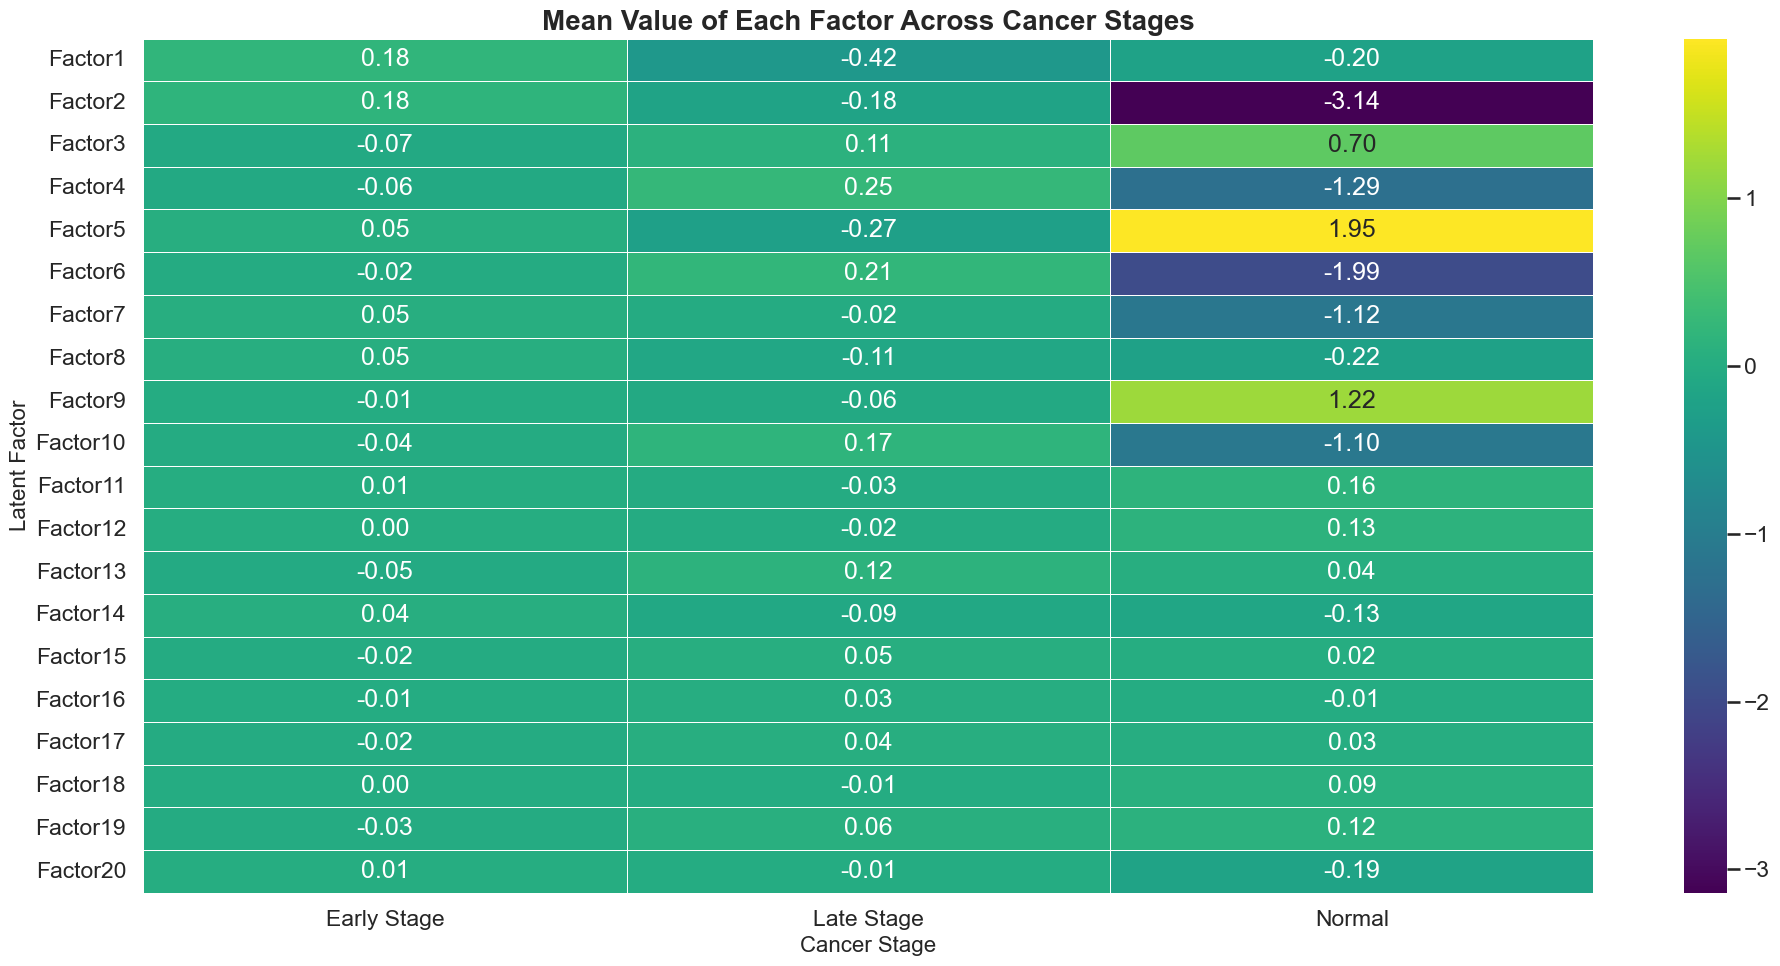


--- 2. Generating Enhanced Volcano Plot for ANOVA ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/summary_anova_volcano_plot_enhanced.png


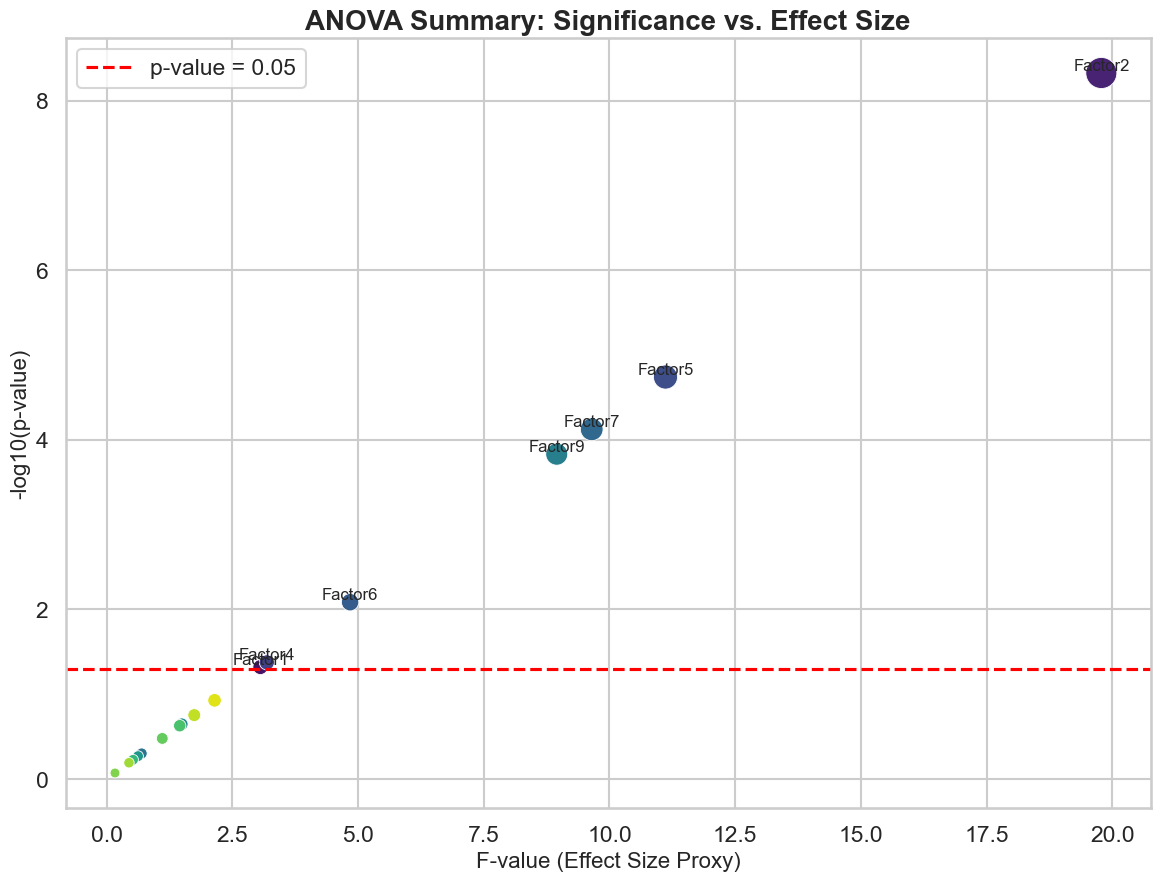


--- 3. Generating Decision Justification Dot Plot ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/summary_decision_dot_plot.png


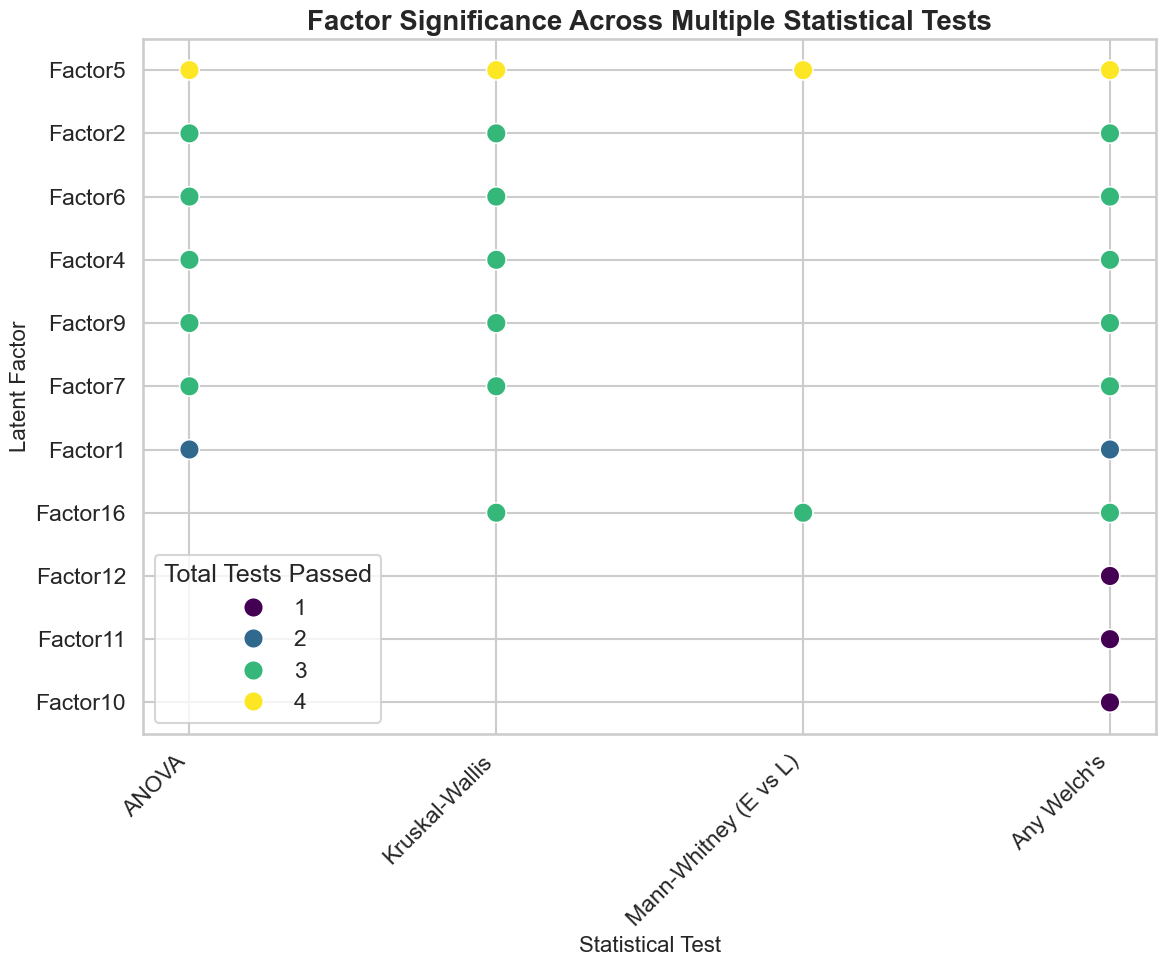


--- 4. Generating PCA Plot of Latent Factors ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/summary_pca_plot.png


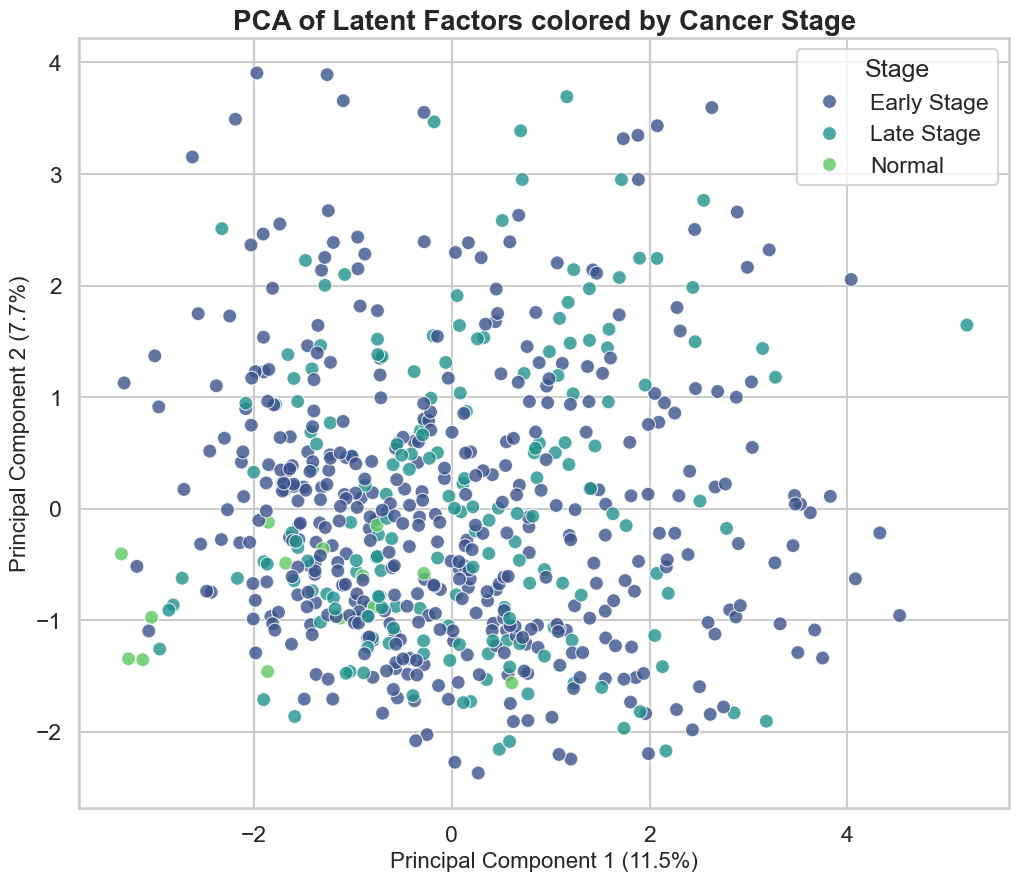


--- 5. Generating Bar Plots with Significance for Top Welch's t-test Factors ---


C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor16_welch_barplot_with_sigs.png


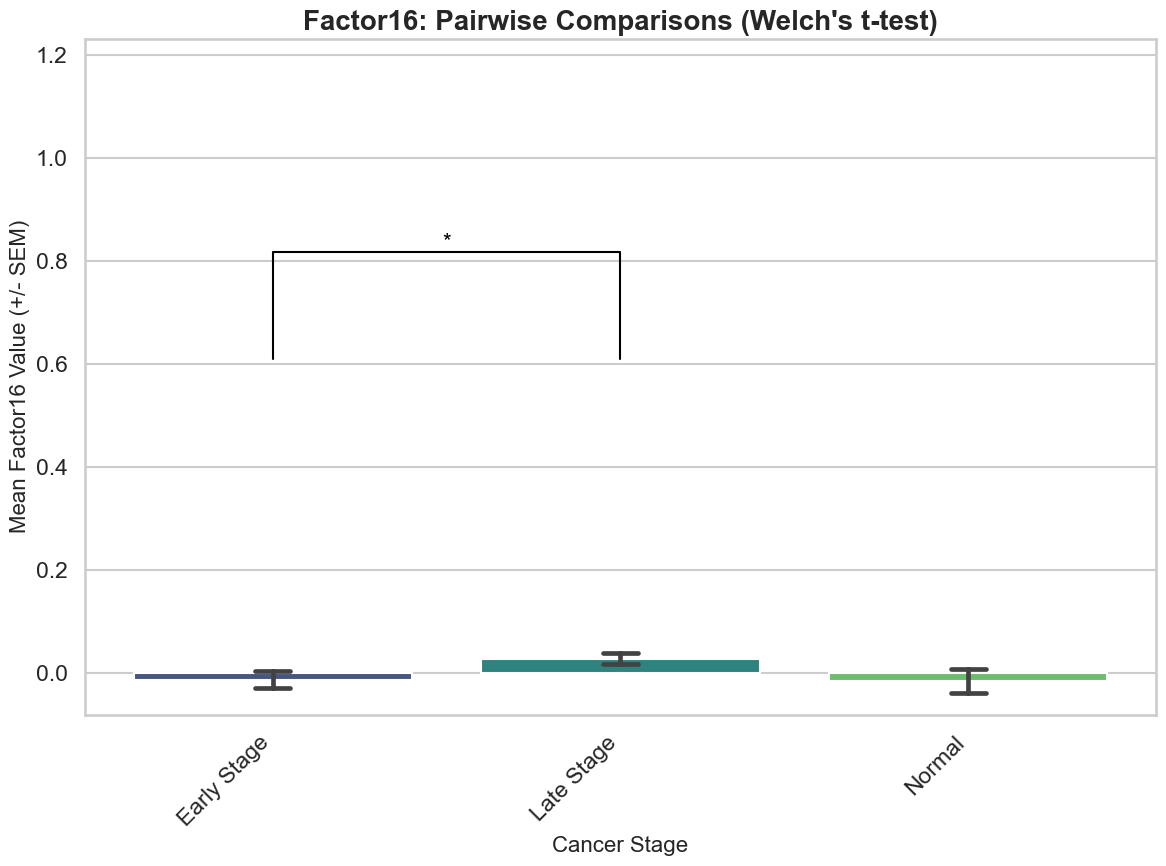

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor2_welch_barplot_with_sigs.png


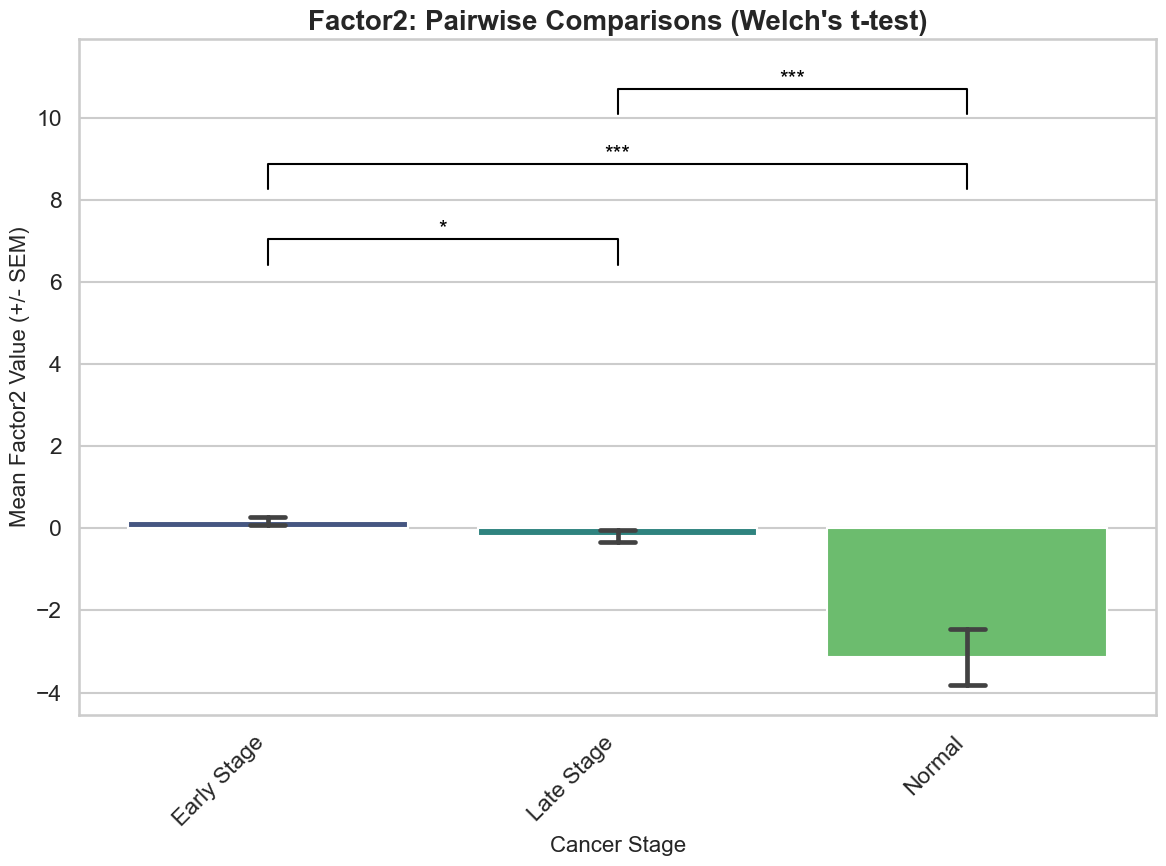

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor4_welch_barplot_with_sigs.png


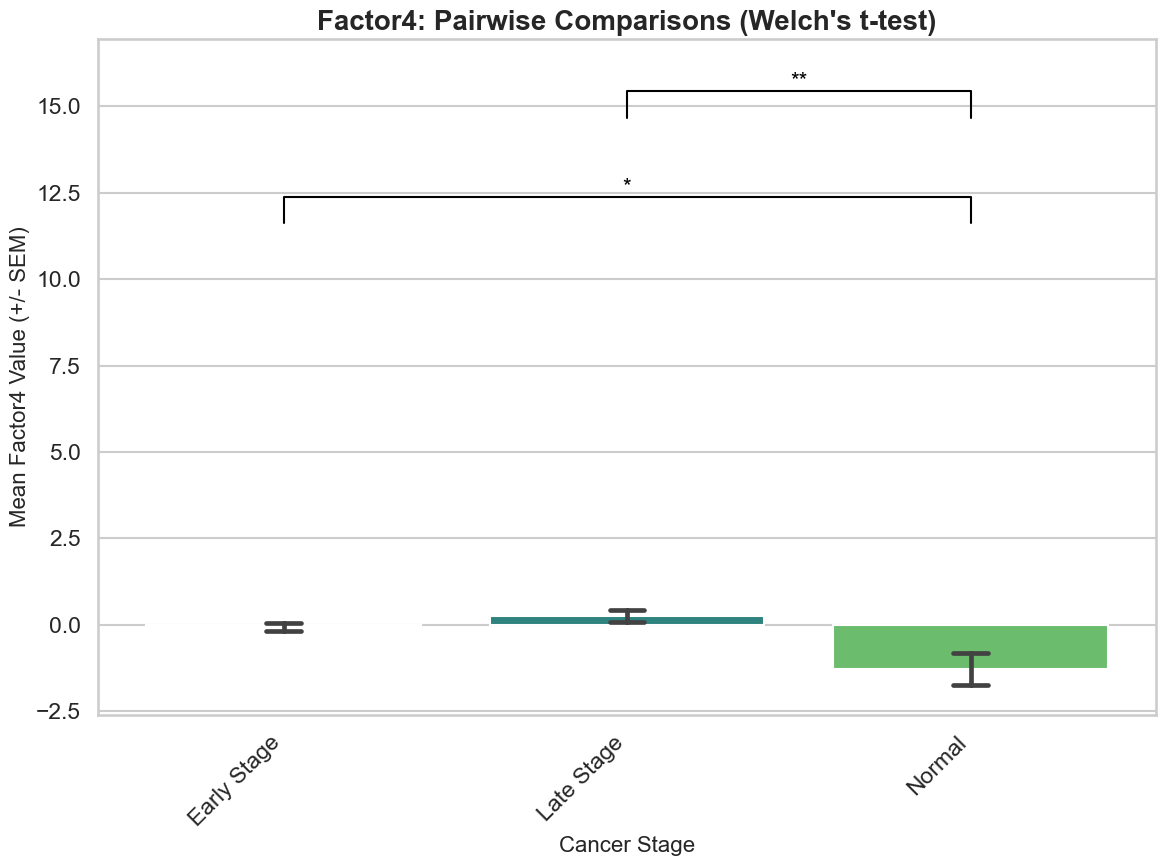

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor5_welch_barplot_with_sigs.png


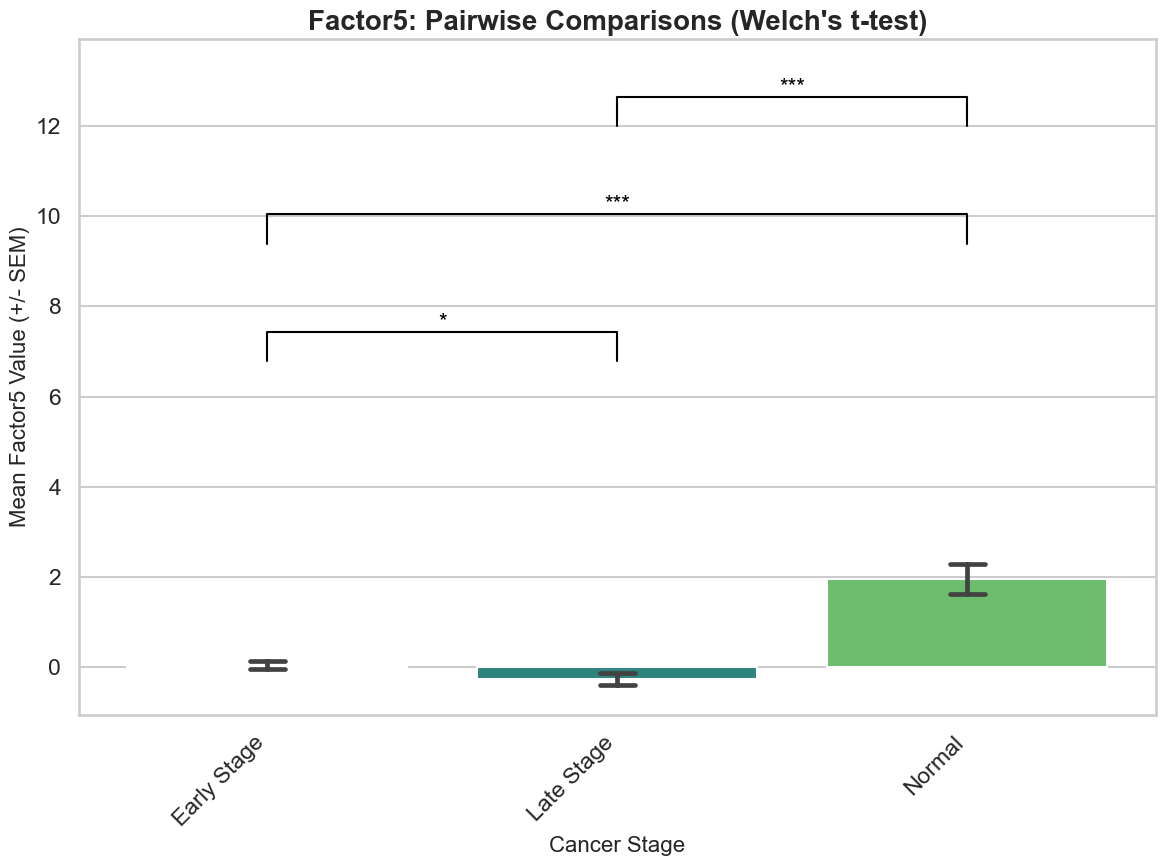

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor6_welch_barplot_with_sigs.png


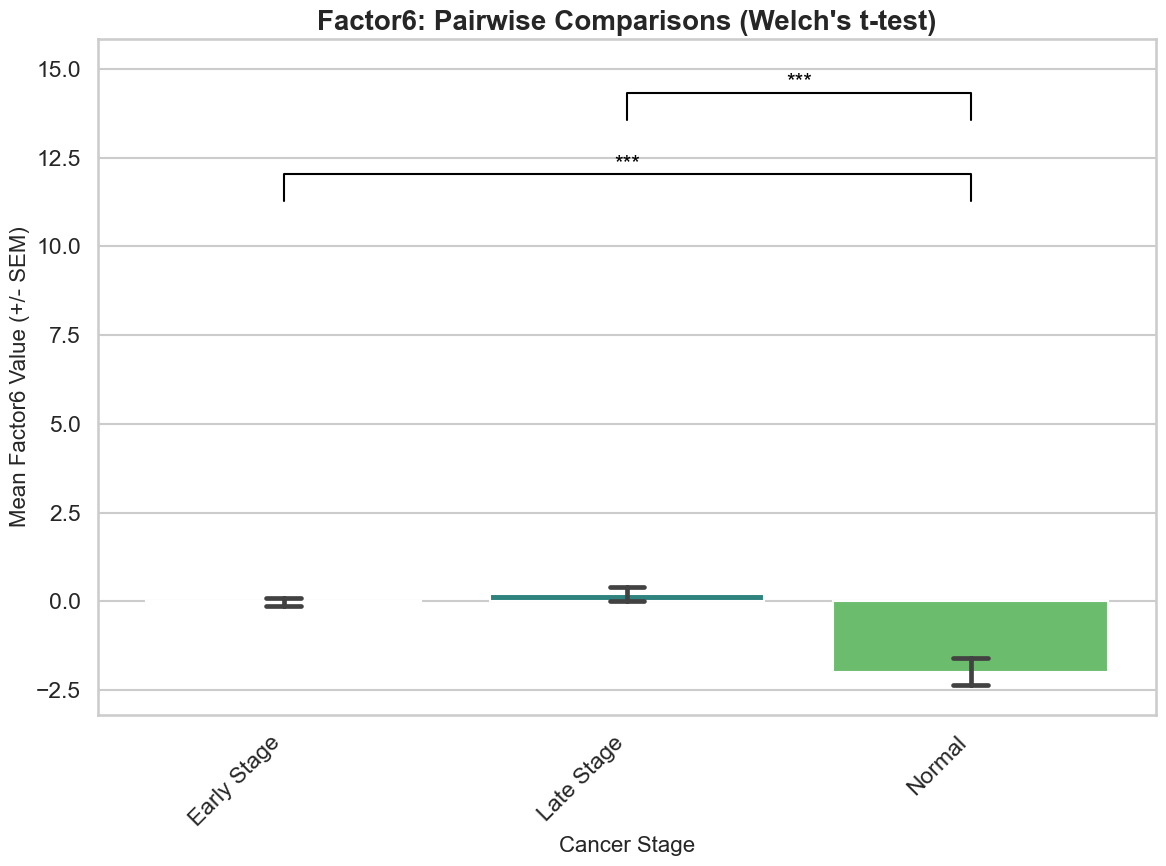

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor7_welch_barplot_with_sigs.png


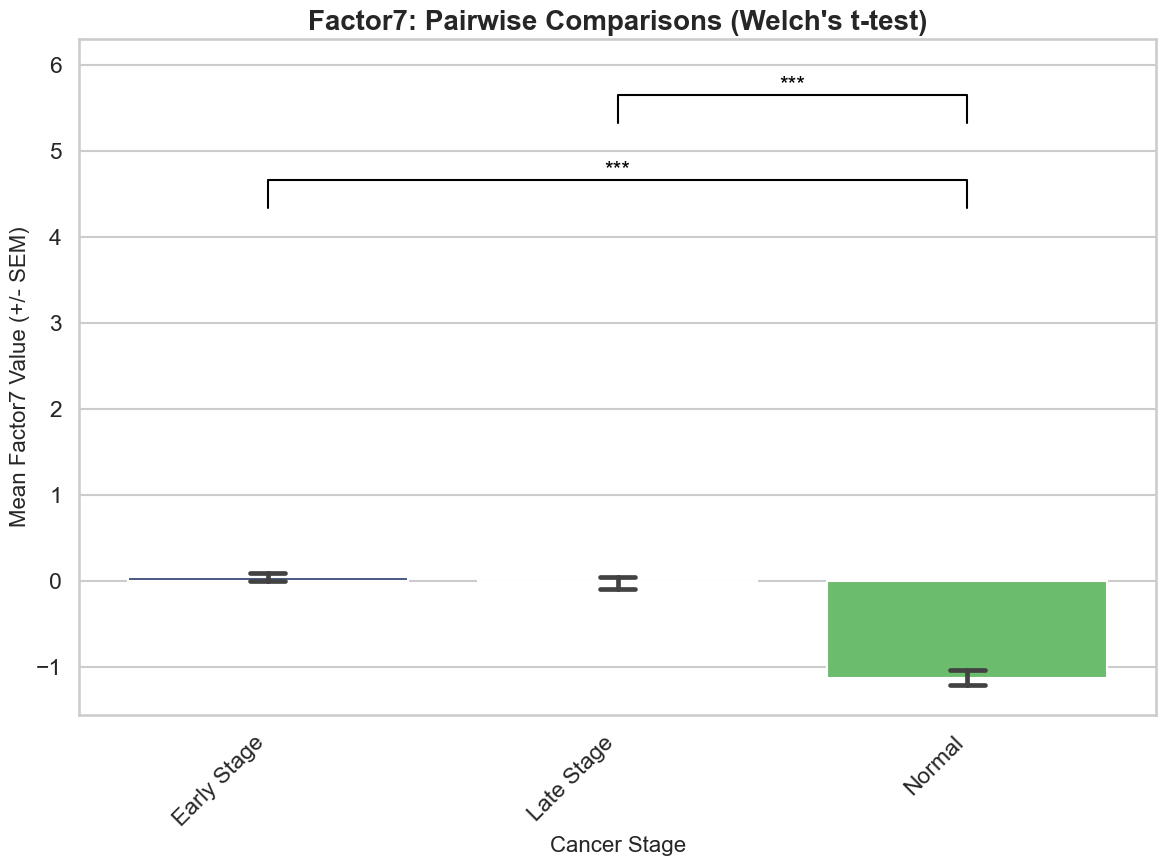

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order,


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor9_welch_barplot_with_sigs.png


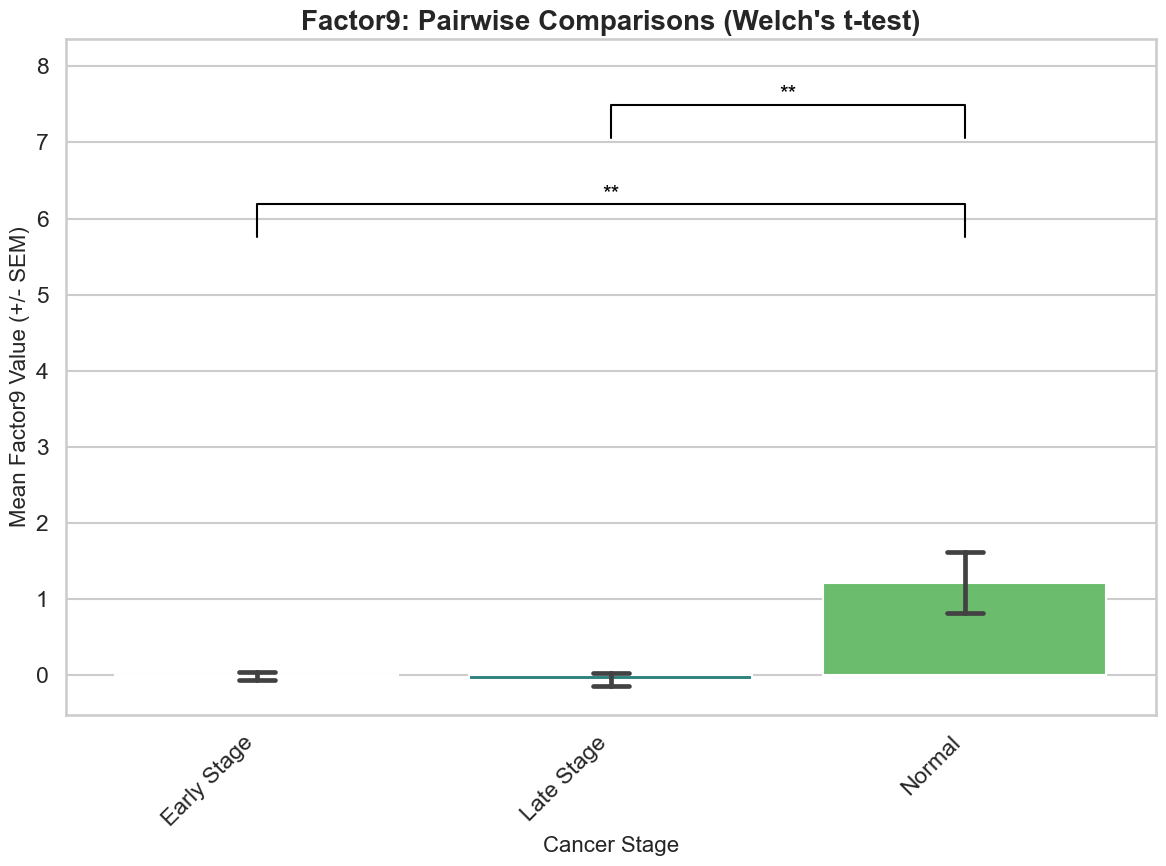


--- 6. Generating Raincloud Plots for Early vs. Late Stage ---


C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x=factor, y='stage_classification', palette='magma', orient='h', inner=None, cut=0)


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor5_mwu_raincloud_plot.png


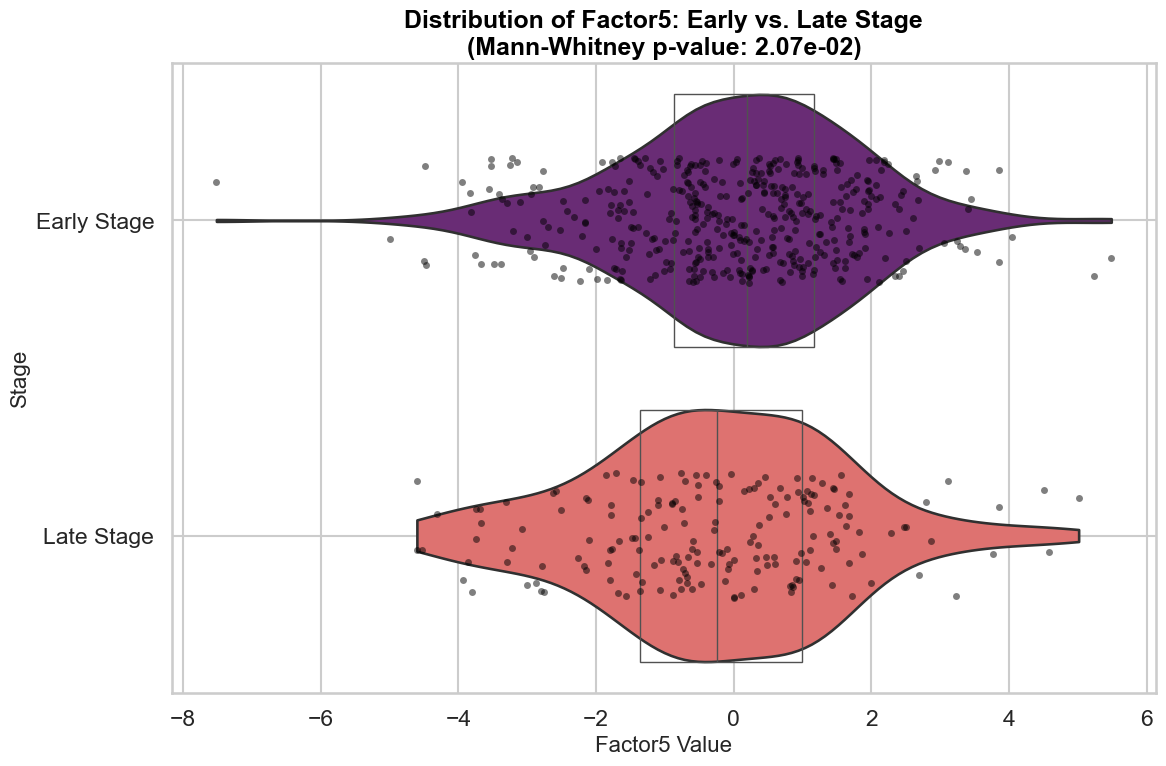

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\2904373226.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x=factor, y='stage_classification', palette='magma', orient='h', inner=None, cut=0)


Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor16_mwu_raincloud_plot.png


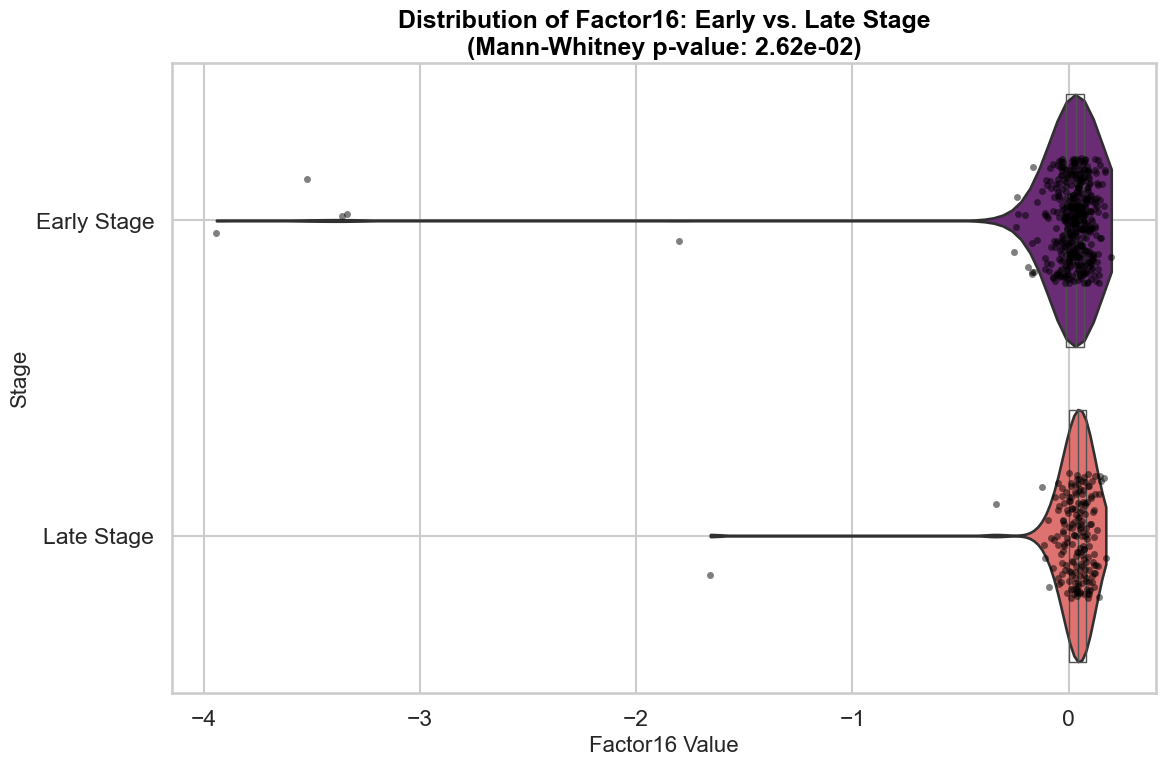


--- Analysis and Visualization Complete ---


In [20]:
print("\n--- Starting Comprehensive Data Visualization ---")
# --- Define a consistent and professional plot style ---
sns.set_style("whitegrid")
sns.set_context("talk")
stage_order = sorted(latent_factors['stage_classification'].unique())
stage_palette = sns.color_palette("viridis", n_colors=len(stage_order))
stage_lut = dict(zip(stage_order, stage_palette))

# --- Plot 1: Heatmap of Mean Factor Values by Stage ---
print("\n--- 1. Generating Heatmap of Mean Factor Values ---")
mean_factor_values = latent_factors.groupby('stage_classification')[latent_factors_columns].mean()
plt.figure(figsize=(20, 10))
sns.heatmap(mean_factor_values.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Mean Value of Each Factor Across Cancer Stages', fontsize=20, weight='bold')
plt.xlabel('Cancer Stage', fontsize=16)
plt.ylabel('Latent Factor', fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
output_path = os.path.join(PLOTS_DIR, "summary_mean_factor_heatmap.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()

# --- Plot 2: Enhanced Volcano Plot for ANOVA Results ---
print("\n--- 2. Generating Enhanced Volcano Plot for ANOVA ---")
plt.figure(figsize=(14, 10))
plot_data = anova_df.copy()
plot_data['-log10(p-value)'] = -np.log10(plot_data['p-value'])
# Scale F-value for better point size visualization
f_value_scaled = (plot_data['F-value'] - plot_data['F-value'].min()) / (plot_data['F-value'].max() - plot_data['F-value'].min()) * 200 + 50
sns.scatterplot(data=plot_data, x='F-value', y='-log10(p-value)', 
                size=f_value_scaled, hue=plot_data.index, palette='viridis', legend=False, sizes=(50, 500))

for factor_name in plot_data.index:
    if plot_data.loc[factor_name, 'p-value'] < 0.05:
        plt.text(x=plot_data.loc[factor_name, 'F-value'], 
                 y=plot_data.loc[factor_name, '-log10(p-value)'], 
                 s=factor_name, fontsize=12, ha='center', va='bottom')

plt.axhline(-np.log10(0.05), color='r', linestyle='--', label='p-value = 0.05')
plt.title('ANOVA Summary: Significance vs. Effect Size', fontsize=20, weight='bold')
plt.xlabel('F-value (Effect Size Proxy)', fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=16)
plt.legend()
plt.grid(True)
output_path = os.path.join(PLOTS_DIR, "summary_anova_volcano_plot_enhanced.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()


# --- Plot 3: Decision Justification Dot Plot ---
print("\n--- 3. Generating Decision Justification Dot Plot ---")
# Create a summary dataframe
summary_sig = pd.DataFrame(index=latent_factors_columns)
summary_sig['ANOVA'] = anova_df['p-value'] < 0.05
summary_sig['Kruskal-Wallis'] = kruskal_df['p-value'] < 0.05
summary_sig['Mann-Whitney (E vs L)'] = early_vs_late_df['p-value'] < 0.05
summary_sig['Any Welch\'s'] = summary_sig.index.isin(significant_welch_results['Factor'].unique())
summary_sig['Total Tests Passed'] = summary_sig.sum(axis=1)
summary_sig = summary_sig.sort_values('Total Tests Passed', ascending=False)
summary_sig_melted = summary_sig.reset_index().melt(id_vars=['index', 'Total Tests Passed'], var_name='Test', value_name='Significant')
summary_sig_melted = summary_sig_melted[summary_sig_melted['Significant']]

plt.figure(figsize=(12, 10))
sns.scatterplot(data=summary_sig_melted, y='index', x='Test', s=200, hue='Total Tests Passed', palette='viridis', legend='full')
plt.title('Factor Significance Across Multiple Statistical Tests', fontsize=20, weight='bold')
plt.ylabel('Latent Factor', fontsize=16)
plt.xlabel('Statistical Test', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
output_path = os.path.join(PLOTS_DIR, "summary_decision_dot_plot.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()

# --- Plot 4: PCA of Latent Factors ---
print("\n--- 4. Generating PCA Plot of Latent Factors ---")
pca = PCA(n_components=2)
scaler = StandardScaler()
lf_scaled = scaler.fit_transform(latent_factors[latent_factors_columns])
principal_components = pca.fit_transform(lf_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['stage_classification'] = latent_factors['stage_classification']

plt.figure(figsize=(12, 10))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='stage_classification', palette=stage_lut, s=100, alpha=0.8)
plt.title('PCA of Latent Factors colored by Cancer Stage', fontsize=20, weight='bold')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=16)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=16)
plt.grid(True)
plt.legend(title='Stage')
output_path = os.path.join(PLOTS_DIR, "summary_pca_plot.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()


# --- Plot 5: Bar Plots with Significance Brackets for Top Welch's t-test Factors ---
print("\n--- 5. Generating Bar Plots with Significance for Top Welch's t-test Factors ---")
top_factors = summary_sig[summary_sig["Total Tests Passed"] > 2].index.tolist()
factors_with_sig_welch = significant_welch_results[significant_welch_results['Factor'].isin(top_factors)].groupby('Factor')

def p_to_stars(p):
    if p <= 0.001: return '***'
    if p <= 0.01: return '**'
    if p <= 0.05: return '*'
    return 'ns'

for factor, group_df in factors_with_sig_welch:
    plt.figure(figsize=(12, 9))
    sns.barplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order, 
                palette='viridis', errorbar='se', capsize=0.1)
    
    y_max = latent_factors.groupby('stage_classification')[factor].max().max()
    y_range = latent_factors[factor].max() - latent_factors[factor].min()
    y_step = y_range * 0.1
    
    y_positions_used = []

    for _, row in group_df.iterrows():
        g1, g2, p = row['Group1'], row['Group2'], row['p-value']
        if g1 not in stage_order or g2 not in stage_order: continue
        x1, x2 = stage_order.index(g1), stage_order.index(g2)
        
        # Logic to stack brackets without overlap
        y = y_max + y_step
        while any(abs(y - pos) < y_step for pos in y_positions_used):
            y += y_step*0.5
        
        h = y_step * 0.5
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
        plt.text((x1+x2)*.5, y+h, p_to_stars(p), ha='center', va='bottom', color='k', fontsize=16)
        y_positions_used.append(y + h)
    
    plt.ylim(top=max(y_positions_used) + y_step if y_positions_used else None)

    plt.title(f'{factor}: Pairwise Comparisons (Welch\'s t-test)', fontsize=20, weight='bold')
    plt.xlabel('Cancer Stage', fontsize=16)
    plt.ylabel(f'Mean {factor} Value (+/- SEM)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    output_path = os.path.join(PLOTS_DIR, f"{factor}_welch_barplot_with_sigs.png")
    plt.savefig(output_path, dpi=300)
    print(f"Saved plot to {output_path}")
    plt.show()

# --- Plot 6: Raincloud Plots for Mann-Whitney U Test ---
print("\n--- 6. Generating Raincloud Plots for Early vs. Late Stage ---")
for factor in significant_early_vs_late.index:
    plt.figure(figsize=(12, 8))
    plot_df = latent_factors[latent_factors['stage_classification'].isin(['Early Stage', 'Late Stage'])]
    
    sns.violinplot(data=plot_df, x=factor, y='stage_classification', palette='magma', orient='h', inner=None, cut=0)
    sns.stripplot(data=plot_df, x=factor, y='stage_classification', jitter=0.2, alpha=0.5, color='black')
    sns.boxplot(data=plot_df, x=factor, y='stage_classification', showcaps=False, boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':0})

    p_value = early_vs_late_df.loc[factor, 'p-value']
    plt.title(f'Distribution of {factor}: Early vs. Late Stage\n(Mann-Whitney p-value: {p_value:.2e})',
              fontsize=18, weight='bold', color='black')
    plt.xlabel(f'{factor} Value', fontsize=16)
    plt.ylabel('Stage', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(PLOTS_DIR, f"{factor}_mwu_raincloud_plot.png")
    plt.savefig(output_path, dpi=300)
    print(f"Saved plot to {output_path}")
    plt.show()

print("\n--- Analysis and Visualization Complete ---")


--- Starting Advanced Visualization Suite ---

Generating detailed plots for all 20 factors.

--- 1. Generating Multivariate Clustering Heatmap ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/summary_clustered_heatmap.png


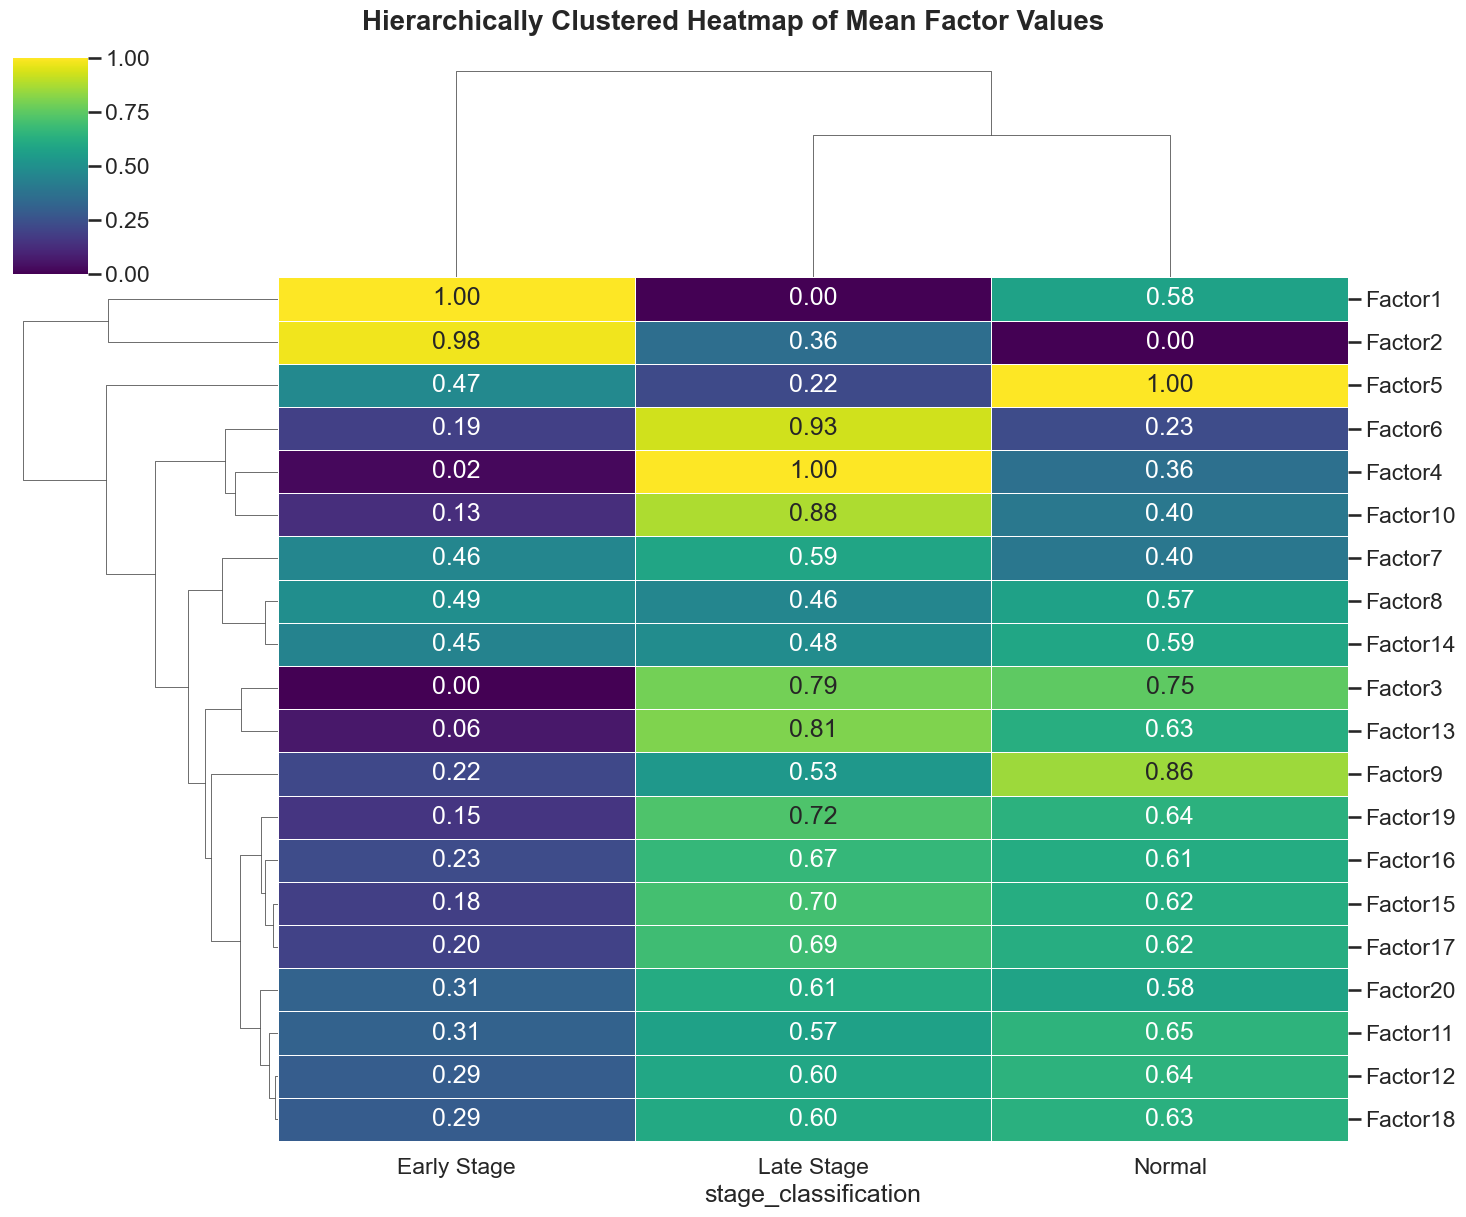


--- 2. Generating Decision Justification Dot Plot ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/summary_decision_dot_plot.png


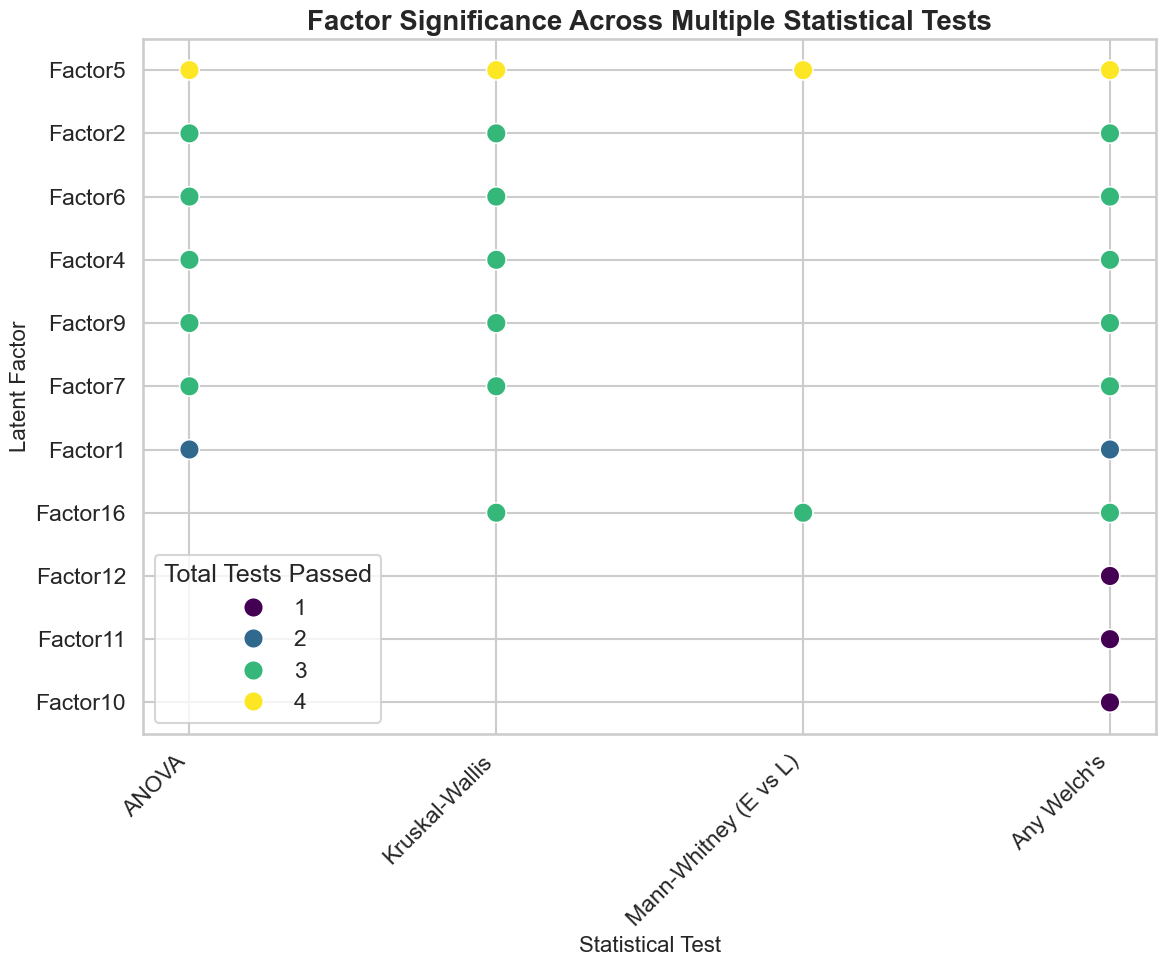


--- 3. Generating ANOVA vs. Kruskal-Wallis Significance Comparison ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/comparison_anova_vs_kruskal_pvalues.png


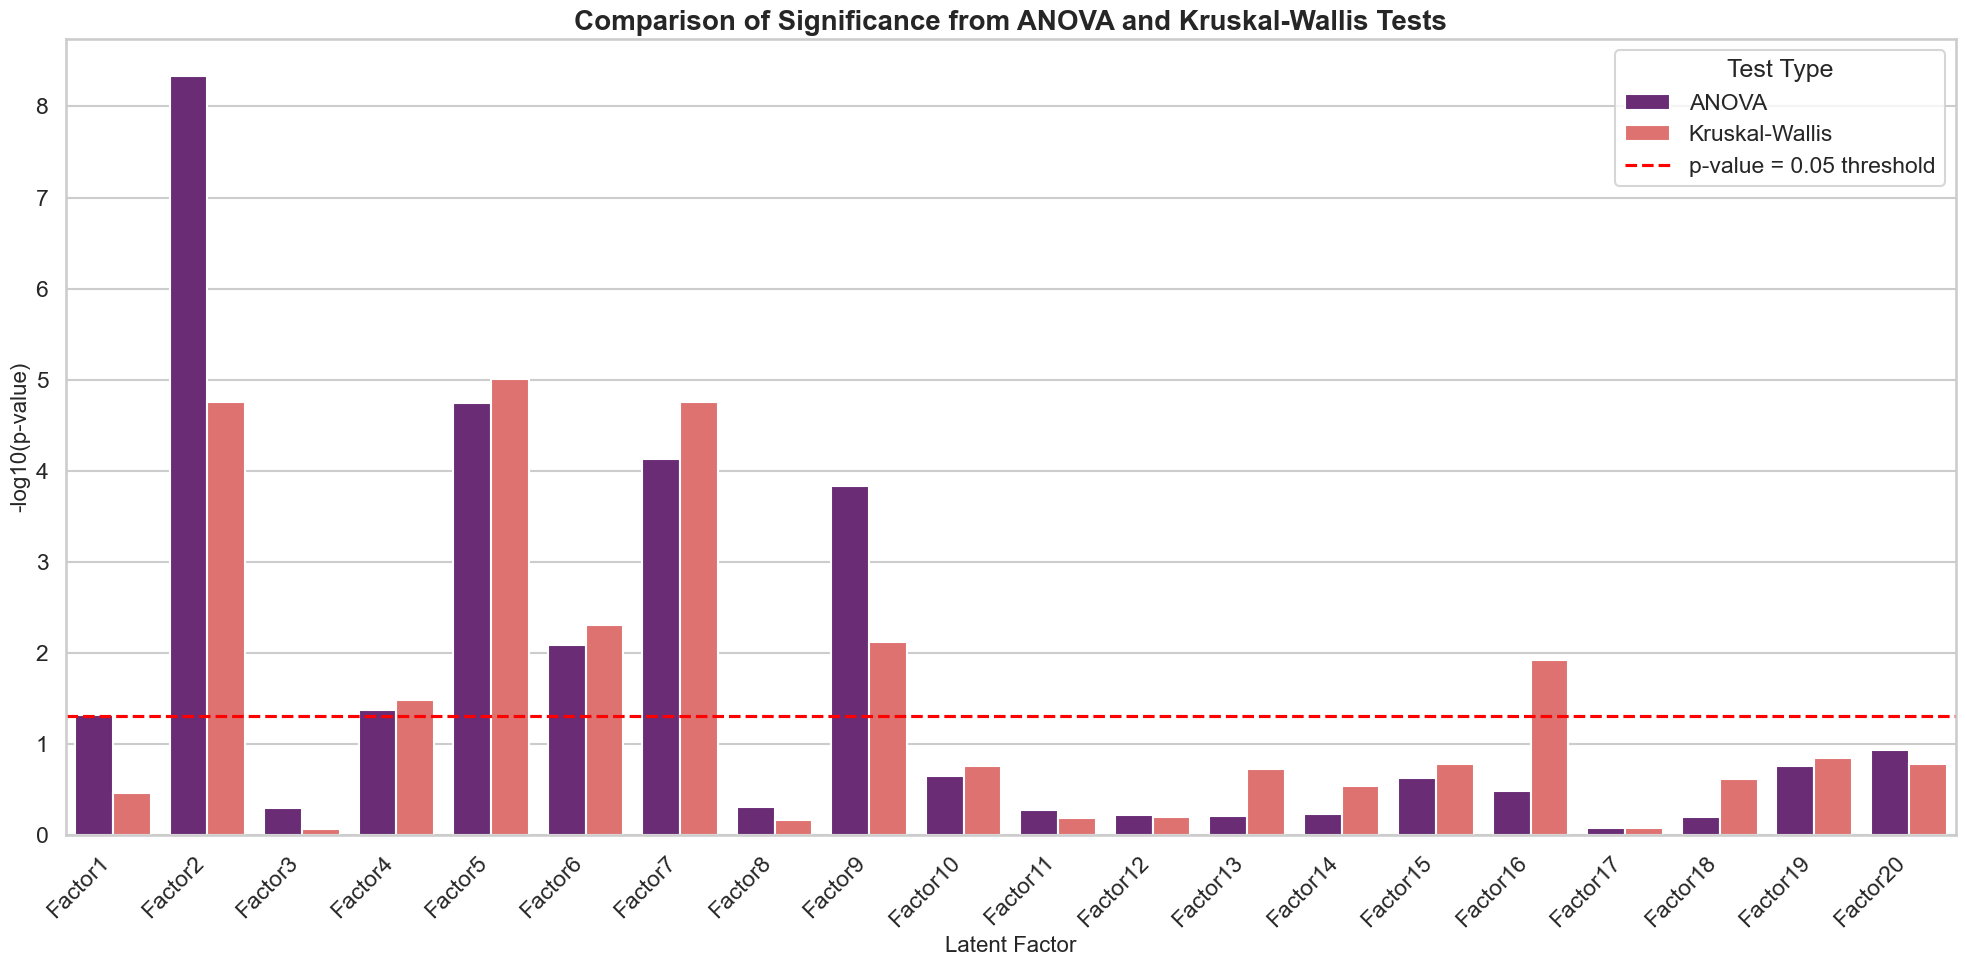


--- 4. Generating ANOVA vs. Kruskal-Wallis Statistic Comparison ---
Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/comparison_anova_vs_kruskal_statistics.png


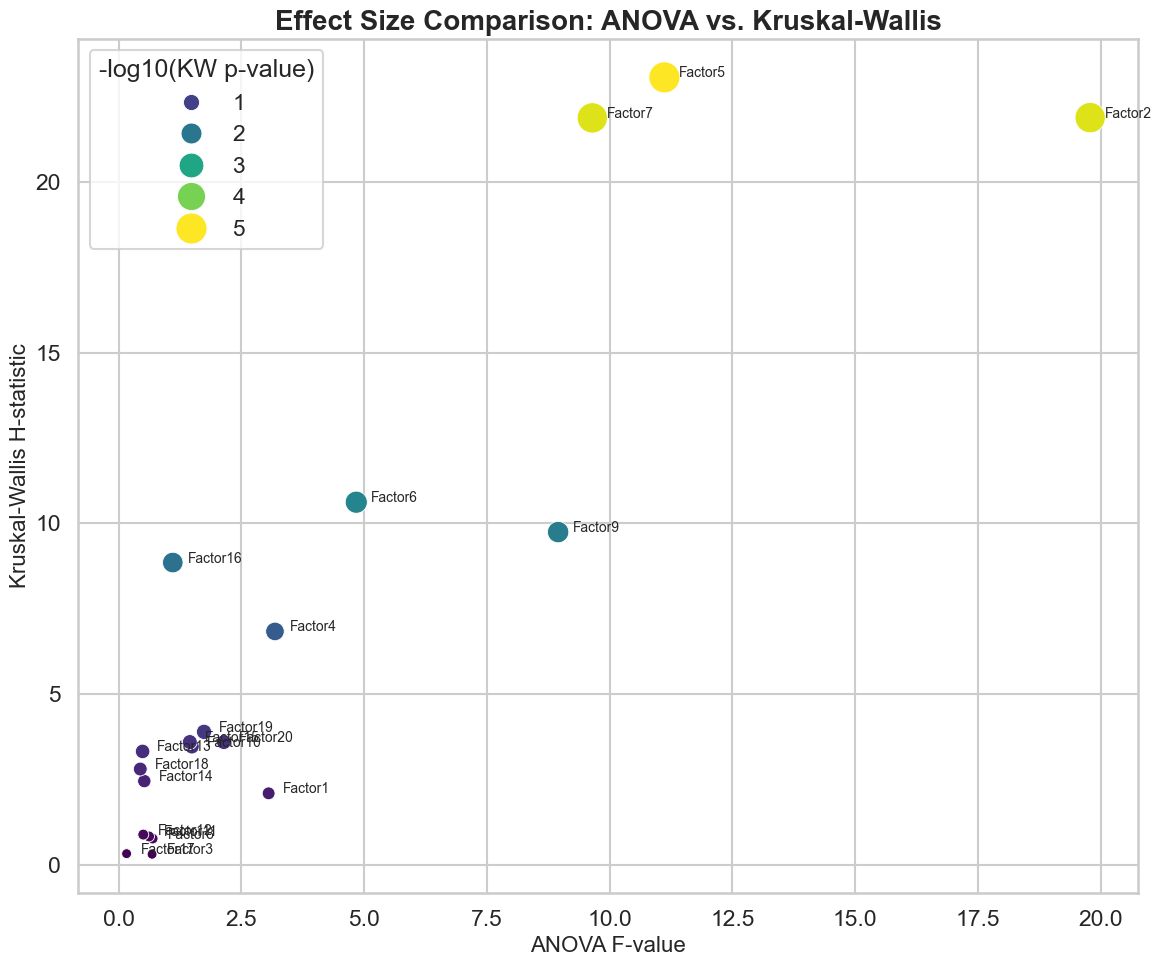


--- 5. Generating Detailed Plots for All Factors ---


C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor1_detailed_stats_violinplot.png


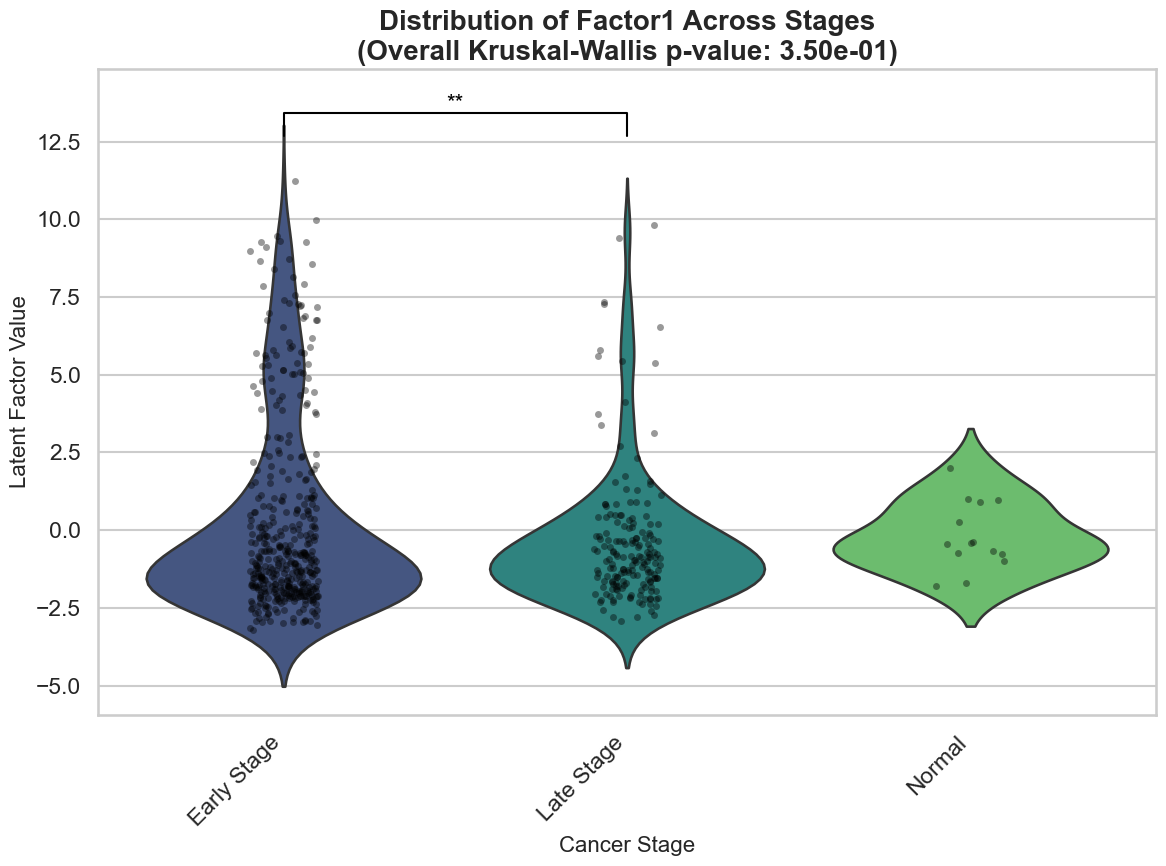

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor2_detailed_stats_violinplot.png


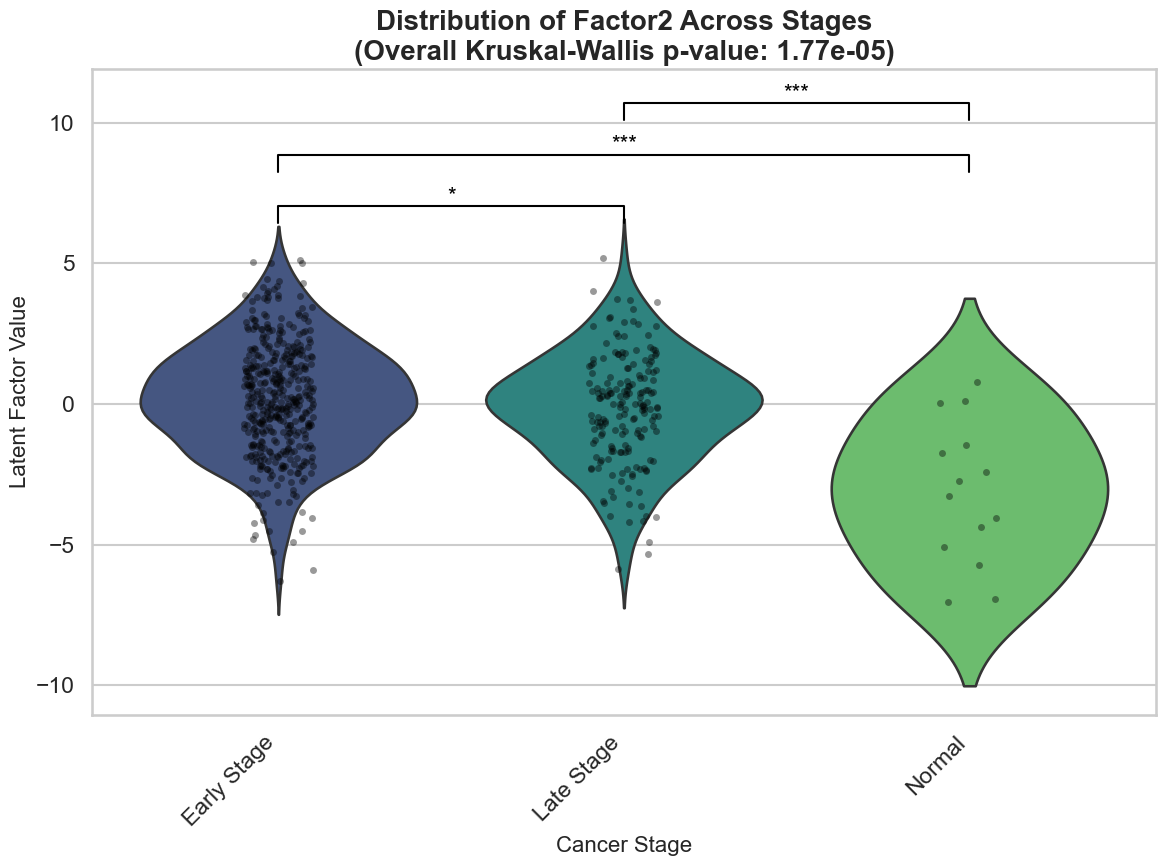

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor3_detailed_stats_violinplot.png


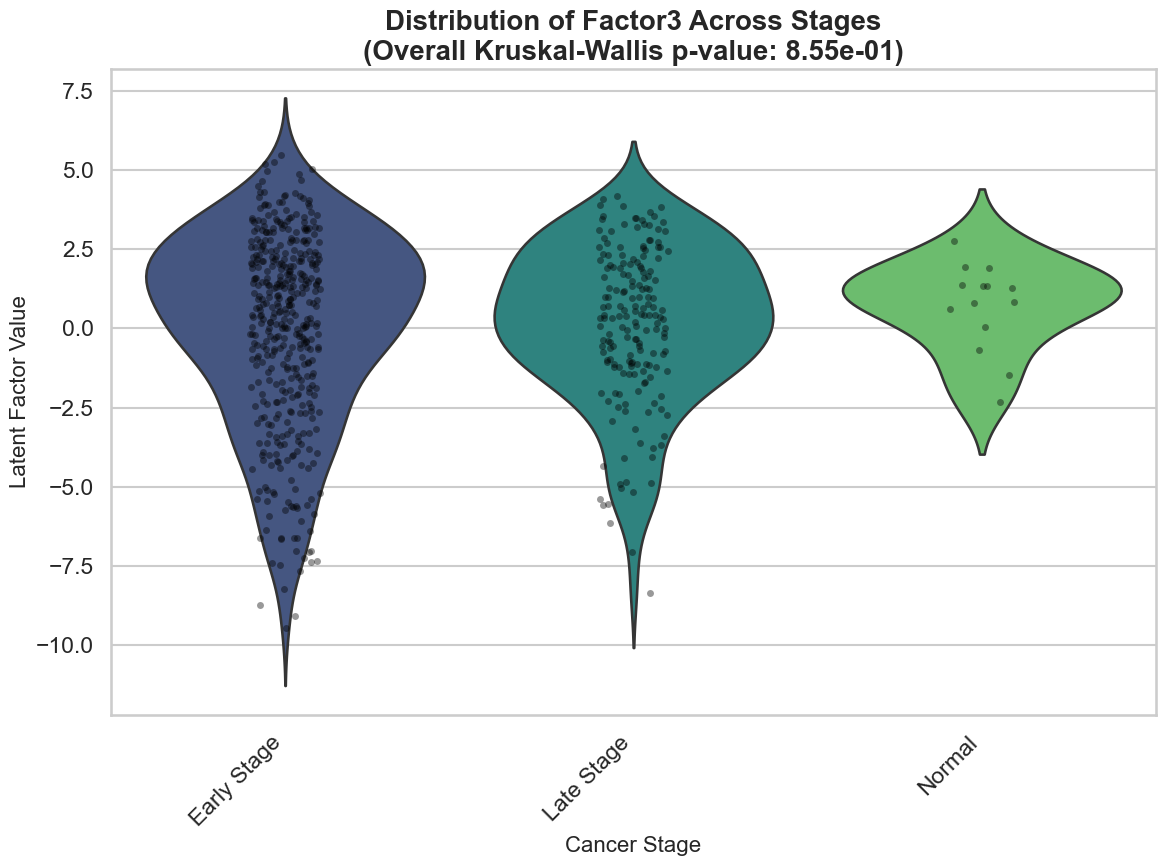

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor4_detailed_stats_violinplot.png


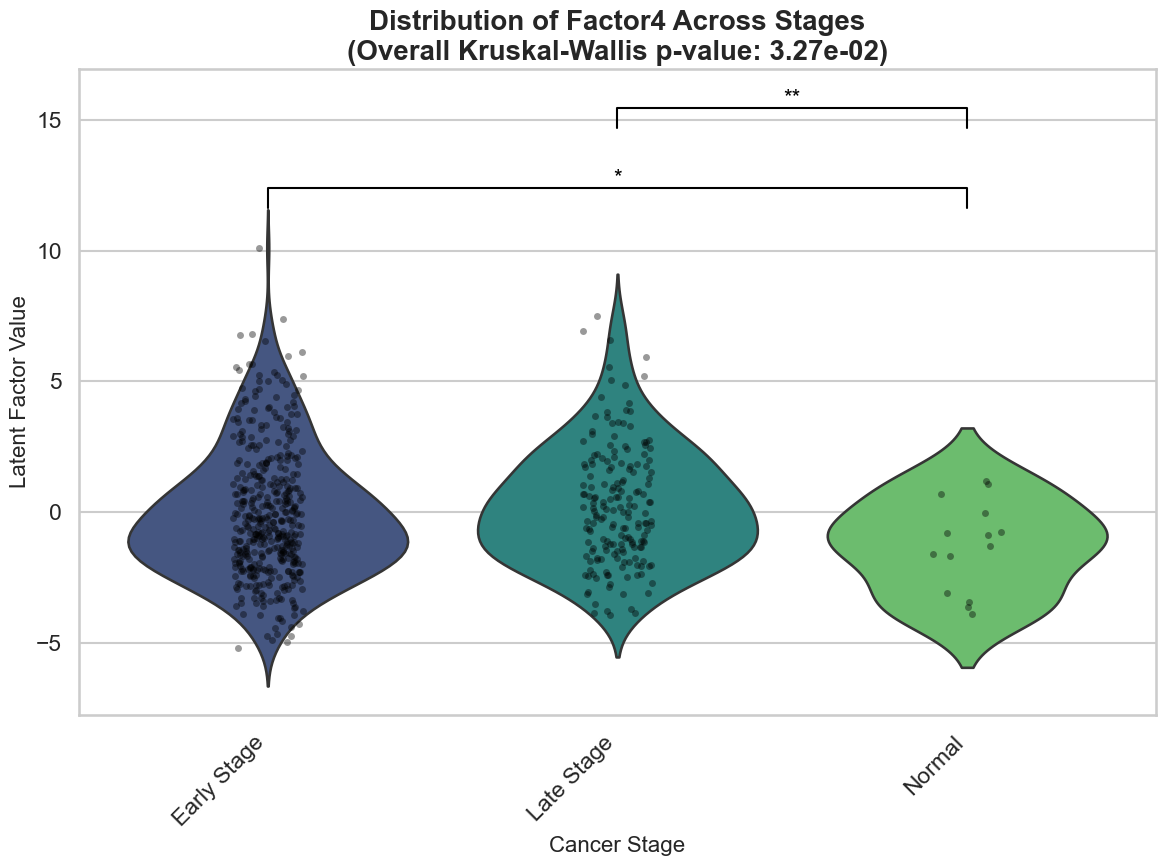

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor5_detailed_stats_violinplot.png


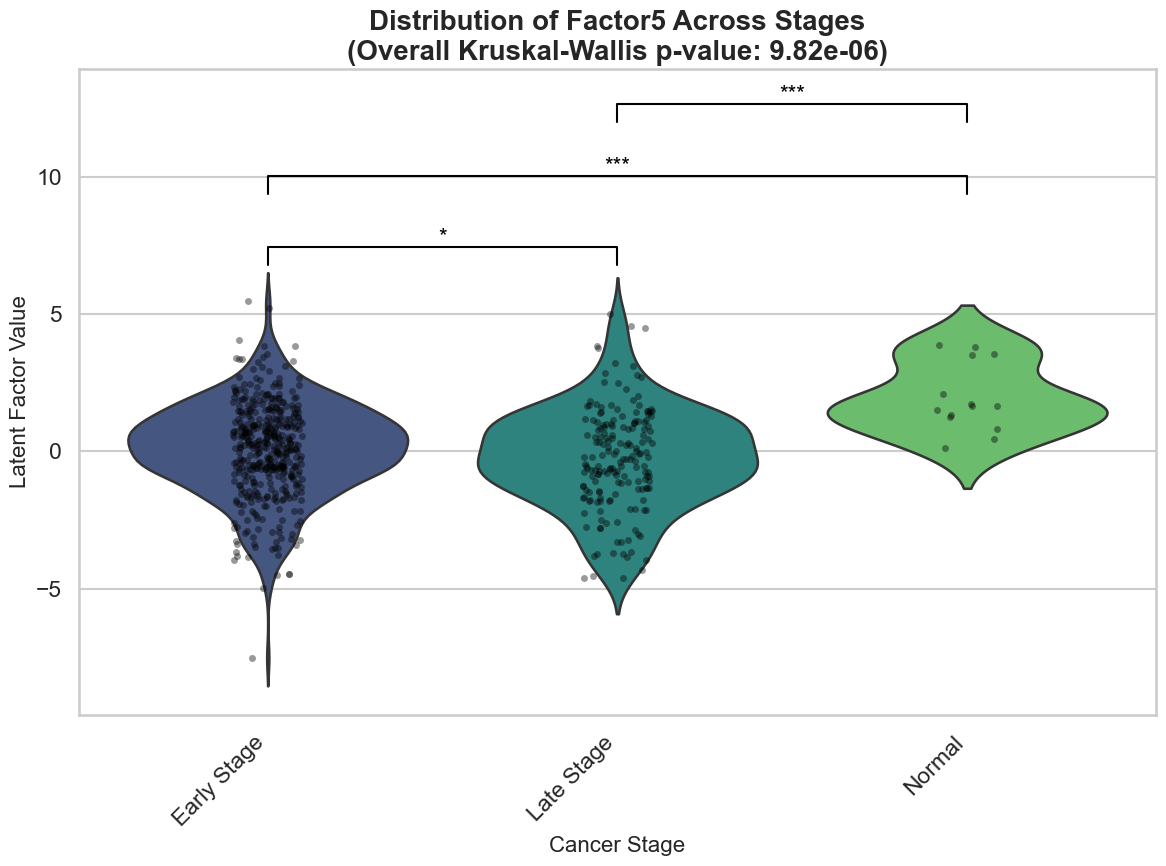

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor6_detailed_stats_violinplot.png


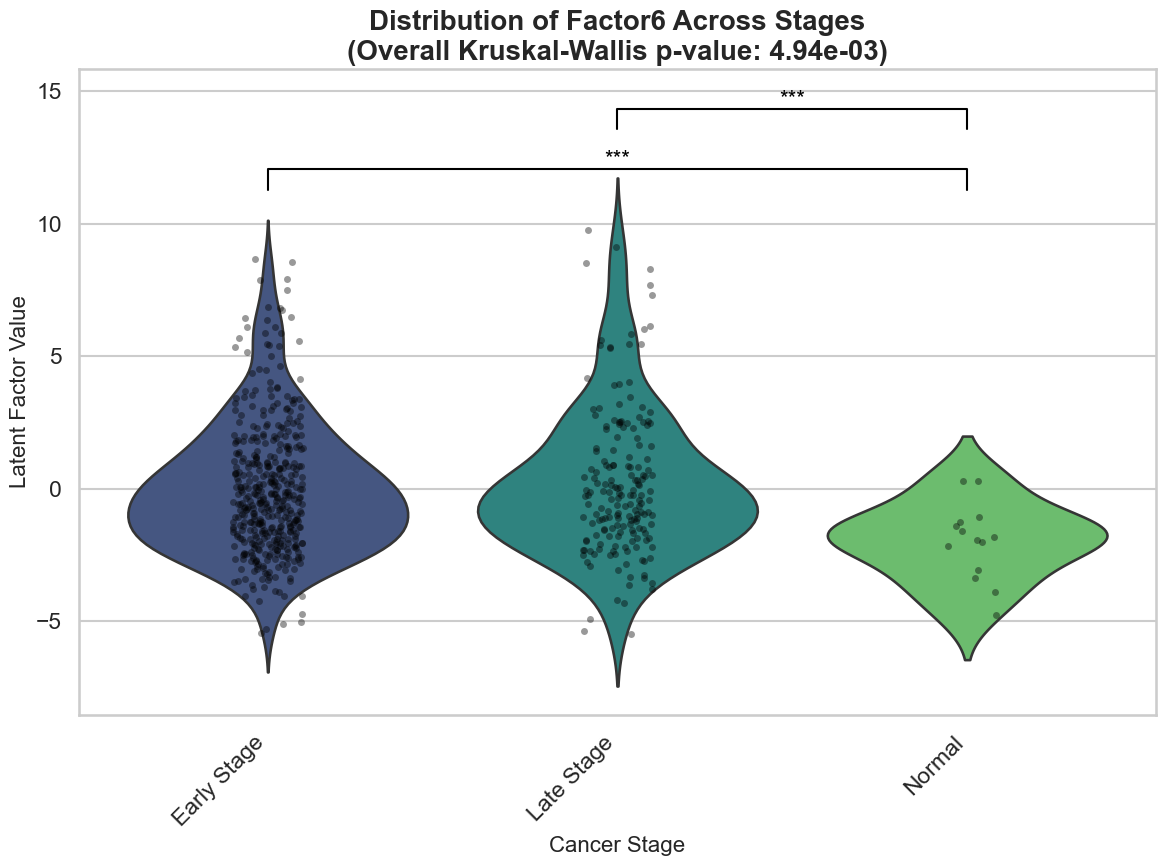

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor7_detailed_stats_violinplot.png


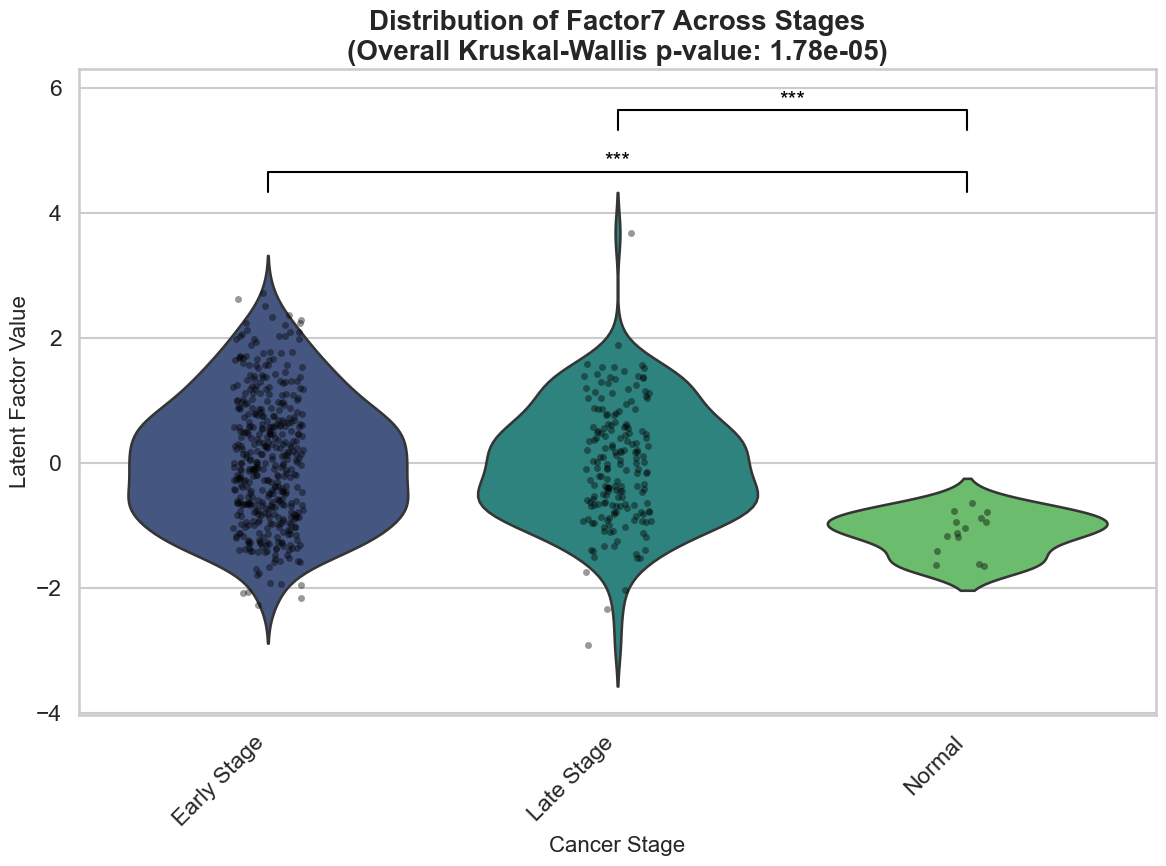

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor8_detailed_stats_violinplot.png


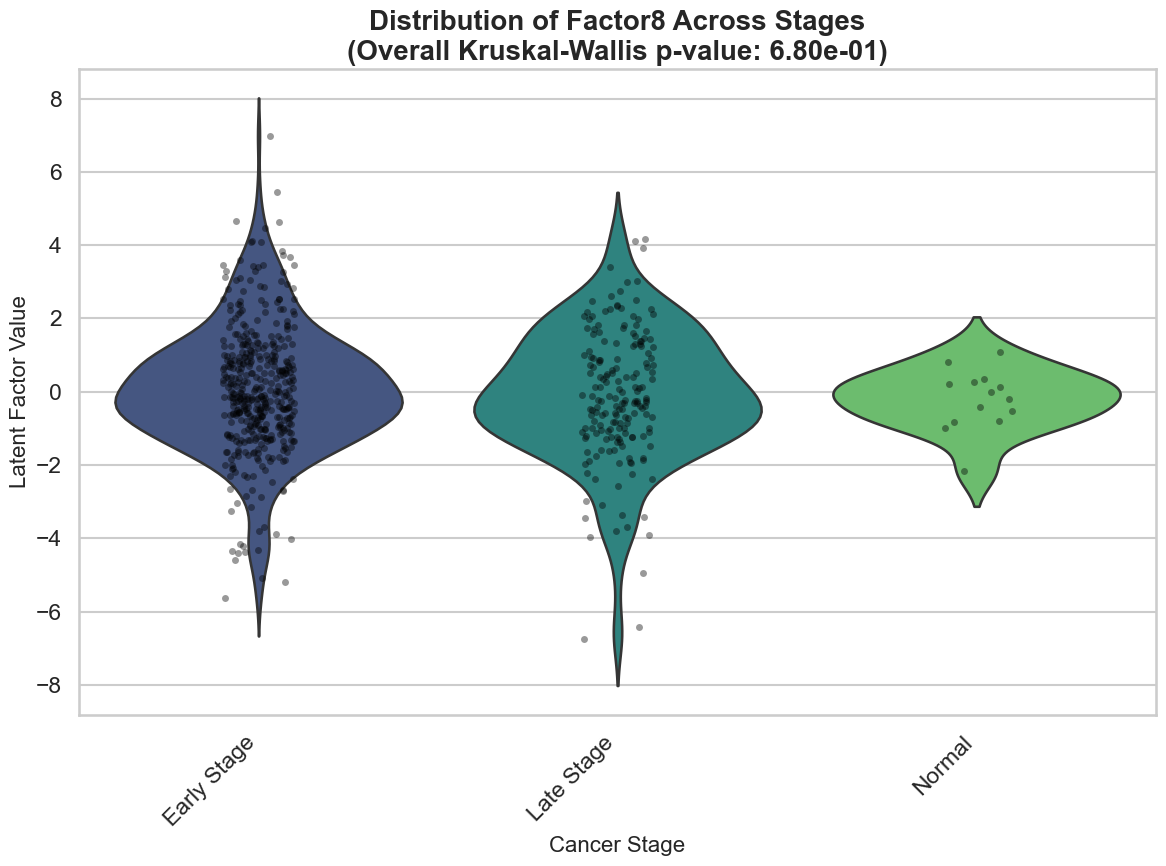

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor9_detailed_stats_violinplot.png


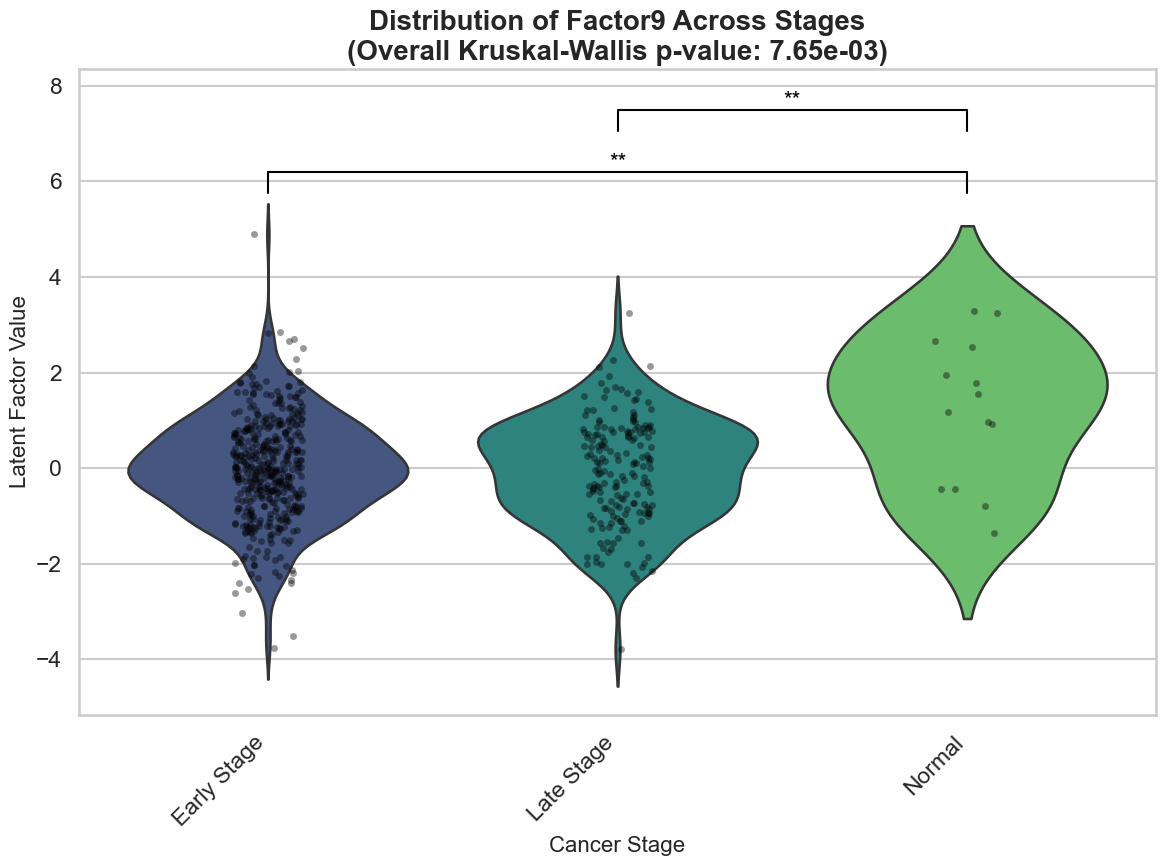

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor10_detailed_stats_violinplot.png


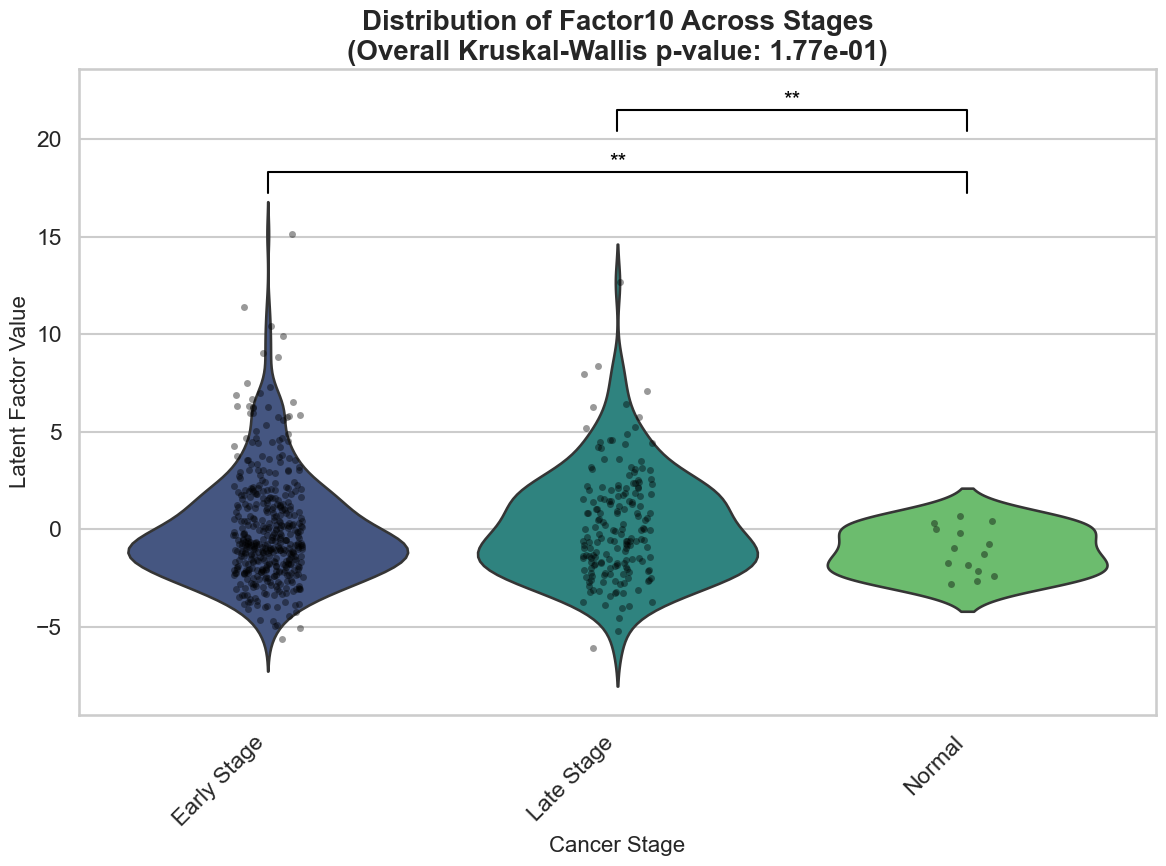

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor11_detailed_stats_violinplot.png


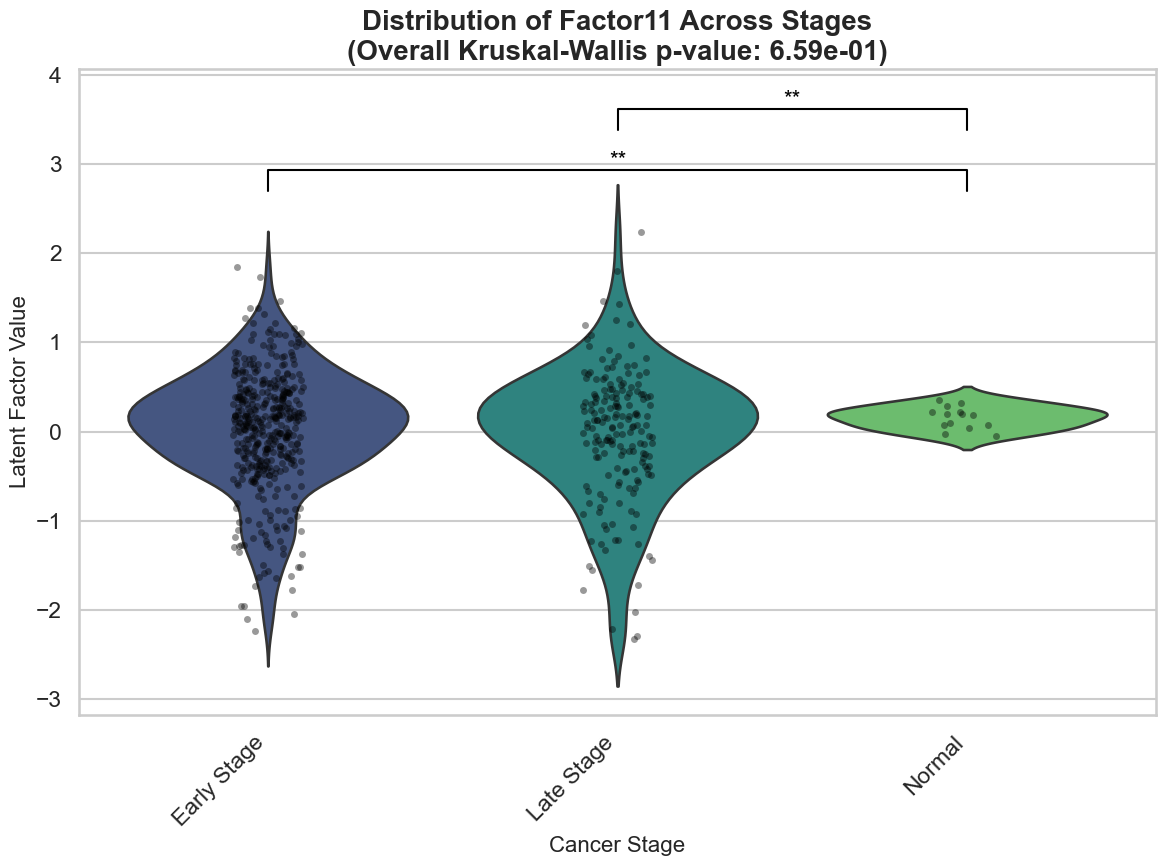

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor12_detailed_stats_violinplot.png


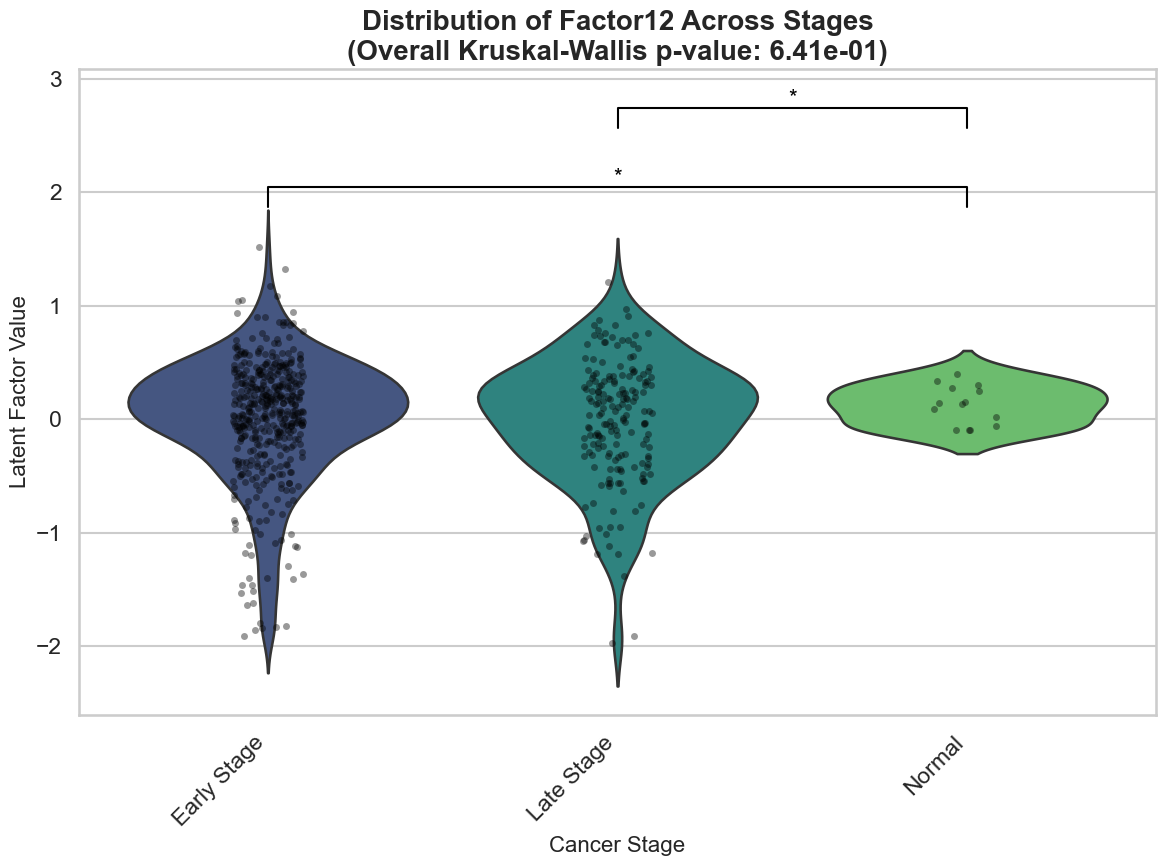

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor13_detailed_stats_violinplot.png


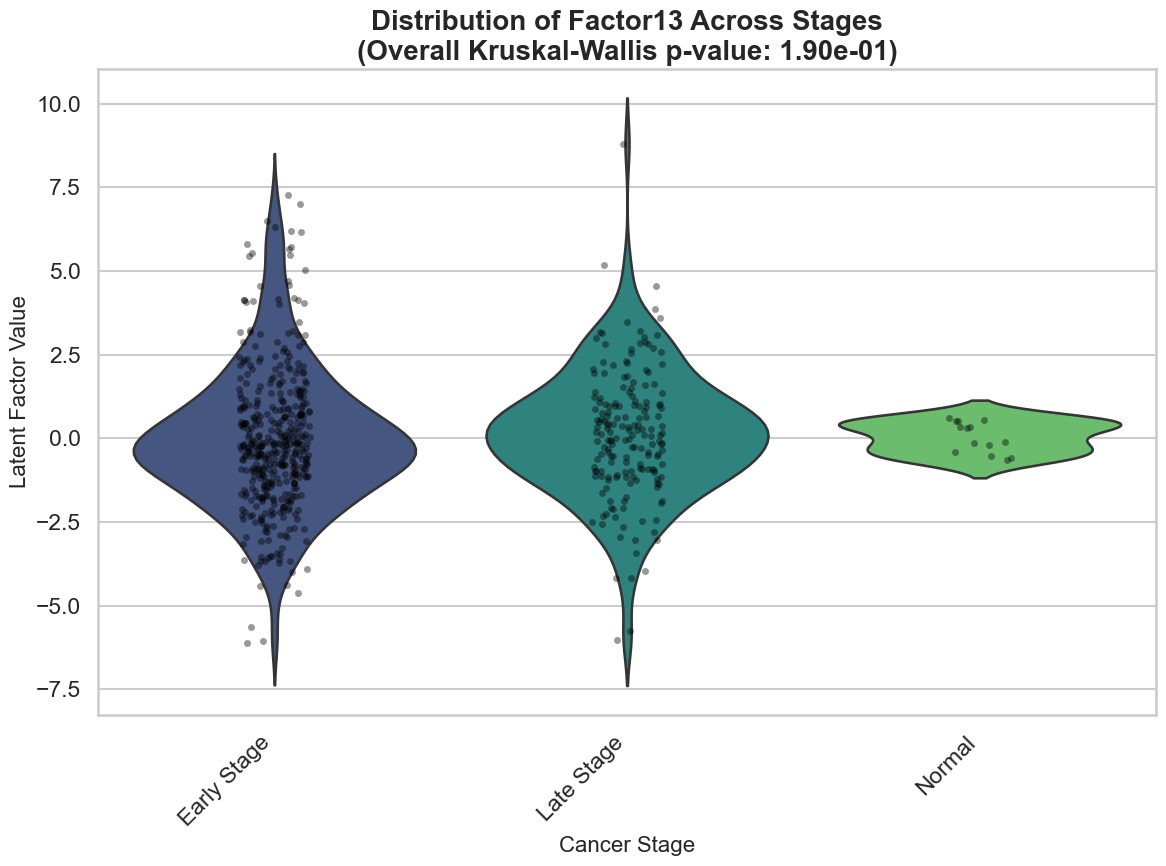

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor14_detailed_stats_violinplot.png


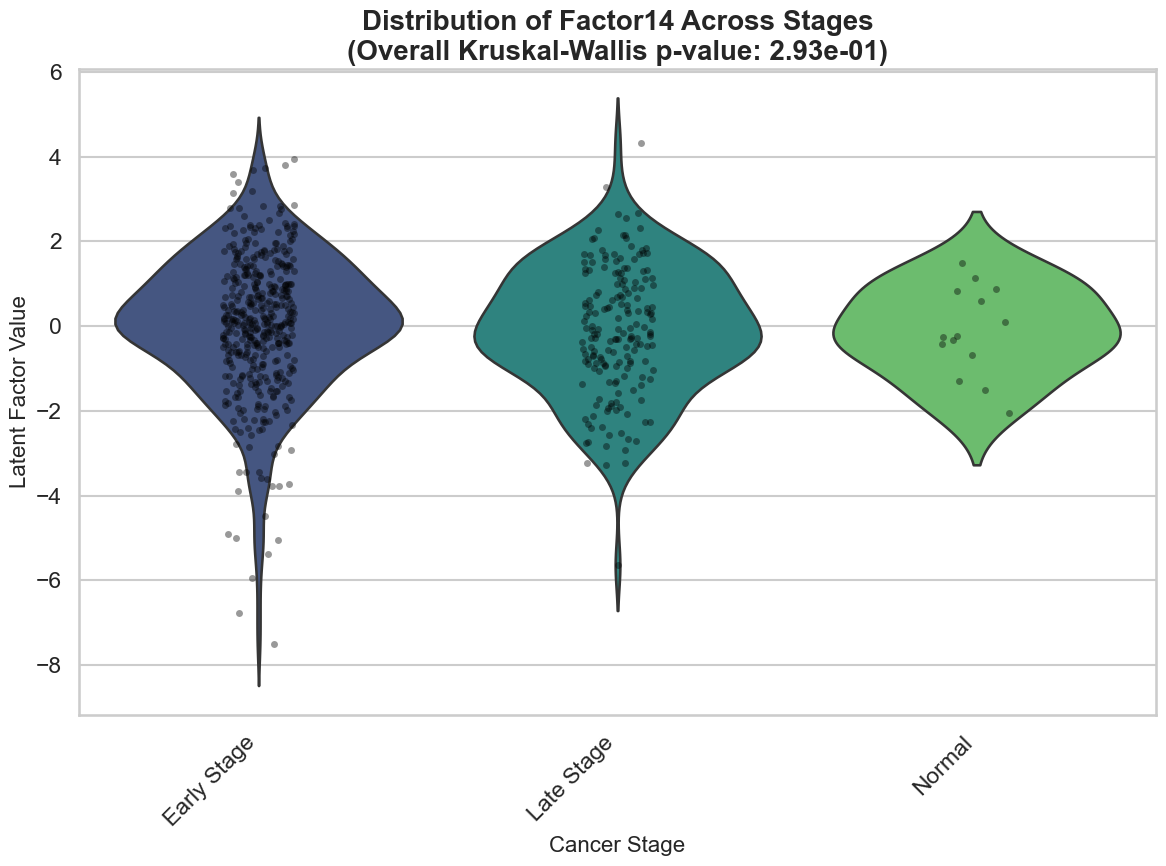

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor15_detailed_stats_violinplot.png


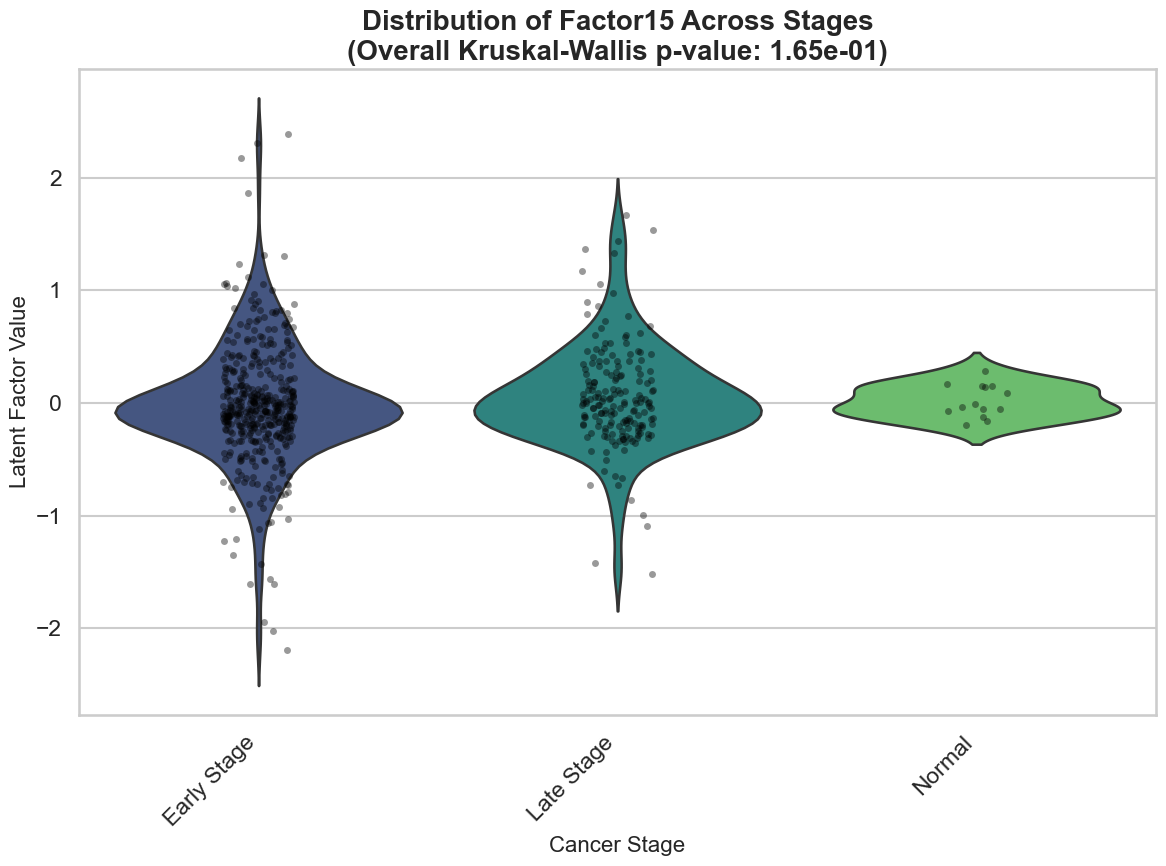

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor16_detailed_stats_violinplot.png


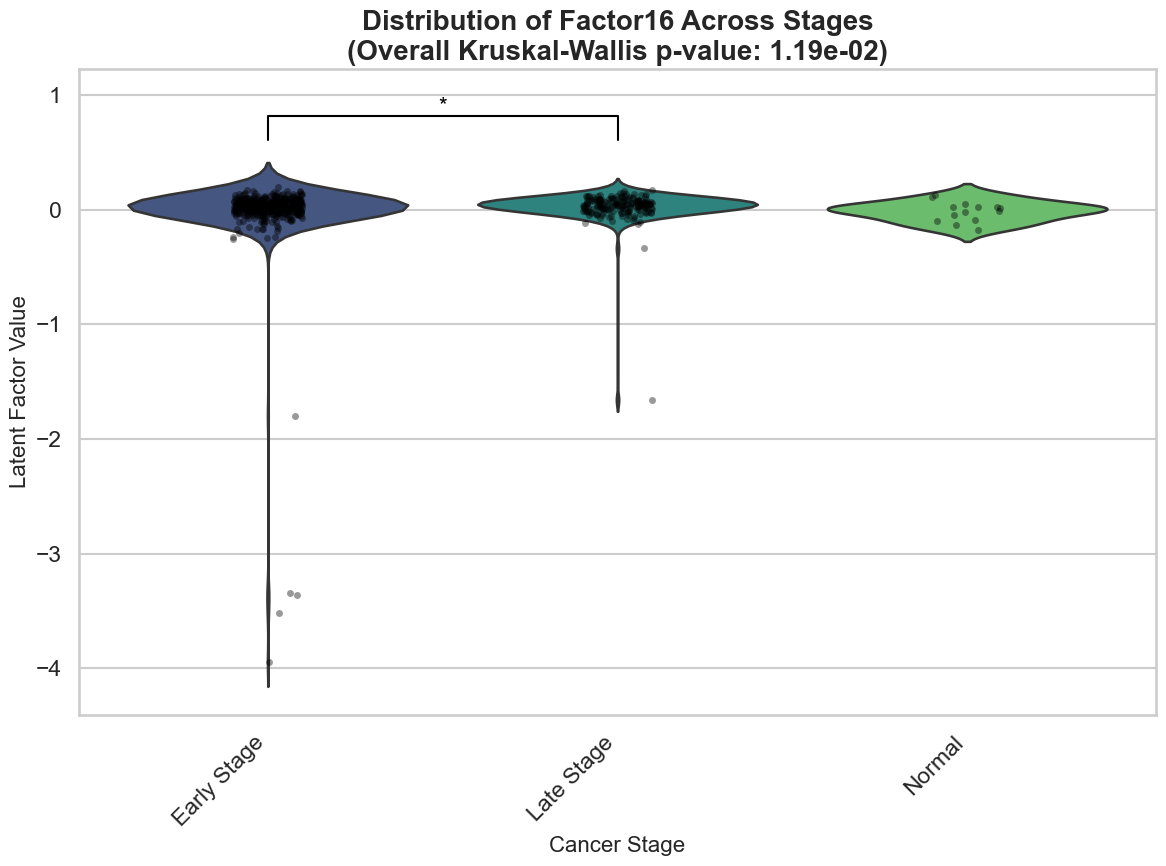

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor17_detailed_stats_violinplot.png


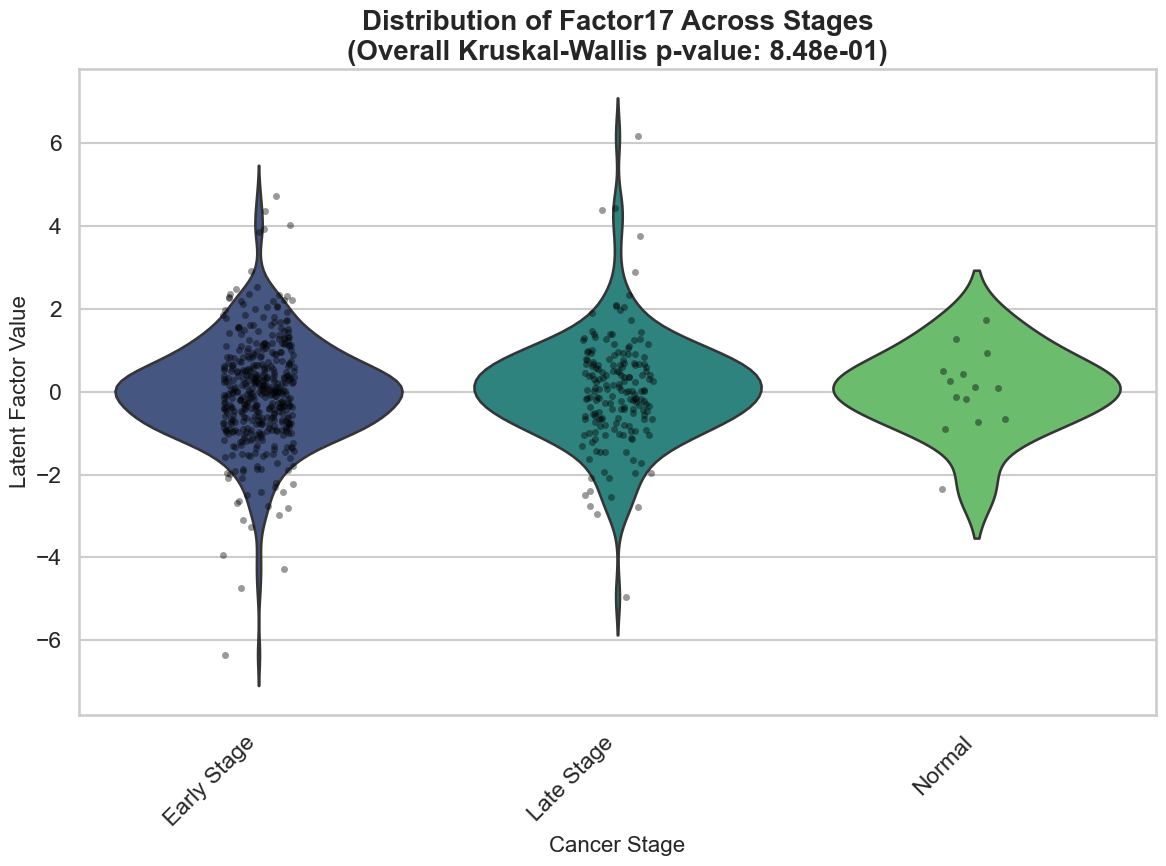

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor18_detailed_stats_violinplot.png


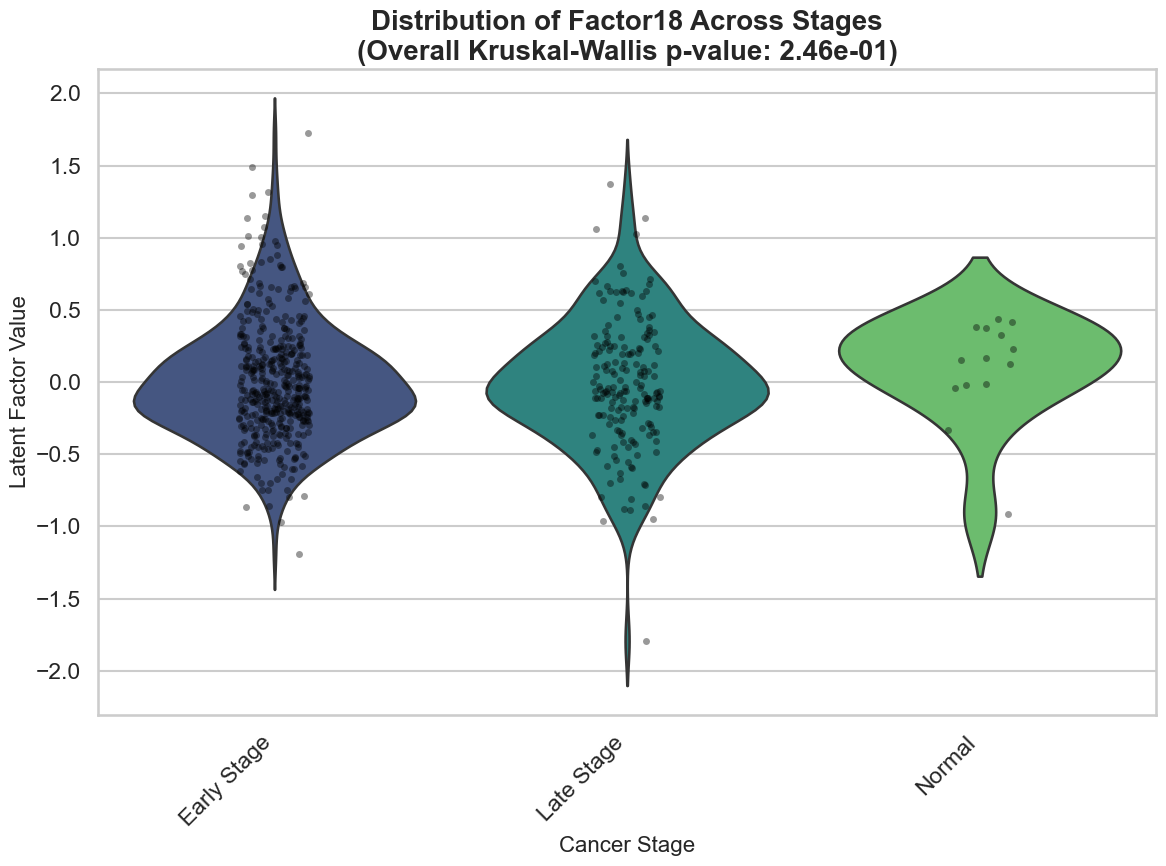

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor19_detailed_stats_violinplot.png


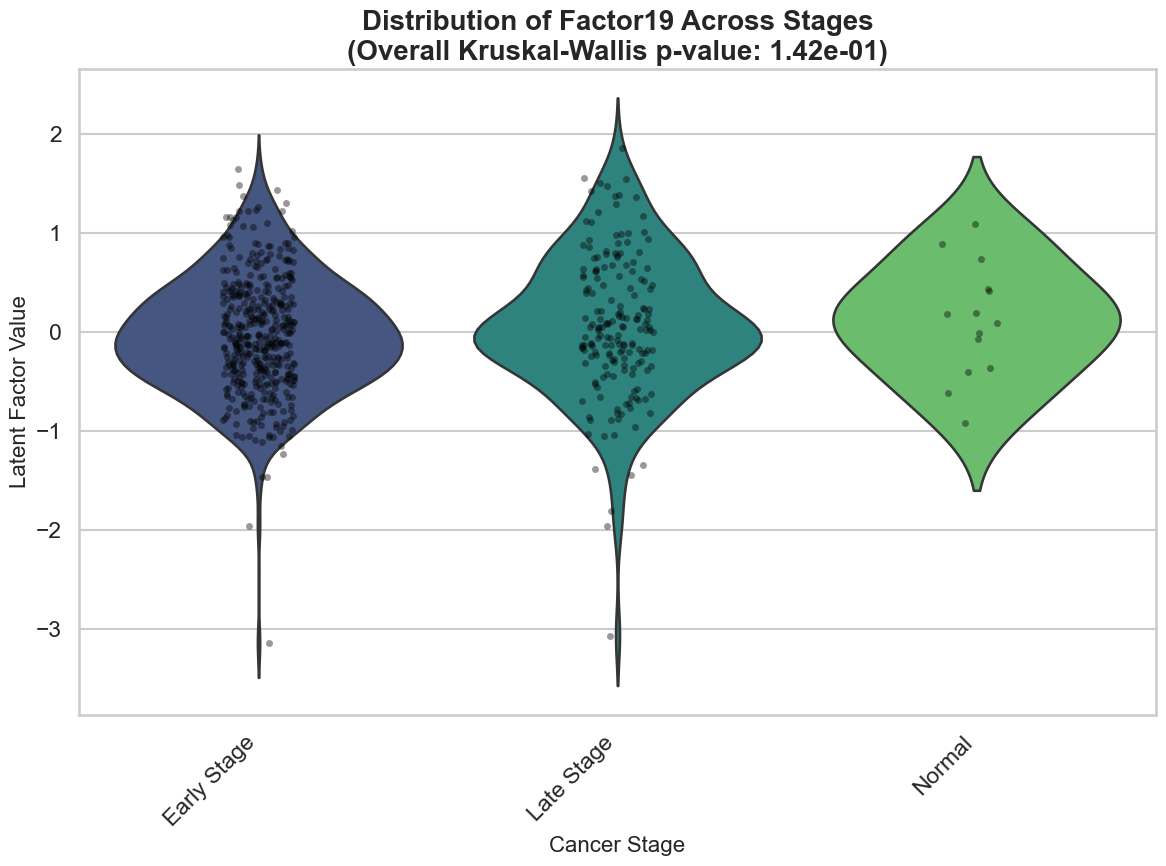

C:\Users\BITS\AppData\Local\Temp\ipykernel_11908\4190291846.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Saved plot to C:/Users/BITS/Documents/BRCA-preprocessed/MOFA-20 results/plots/Factor20_detailed_stats_violinplot.png


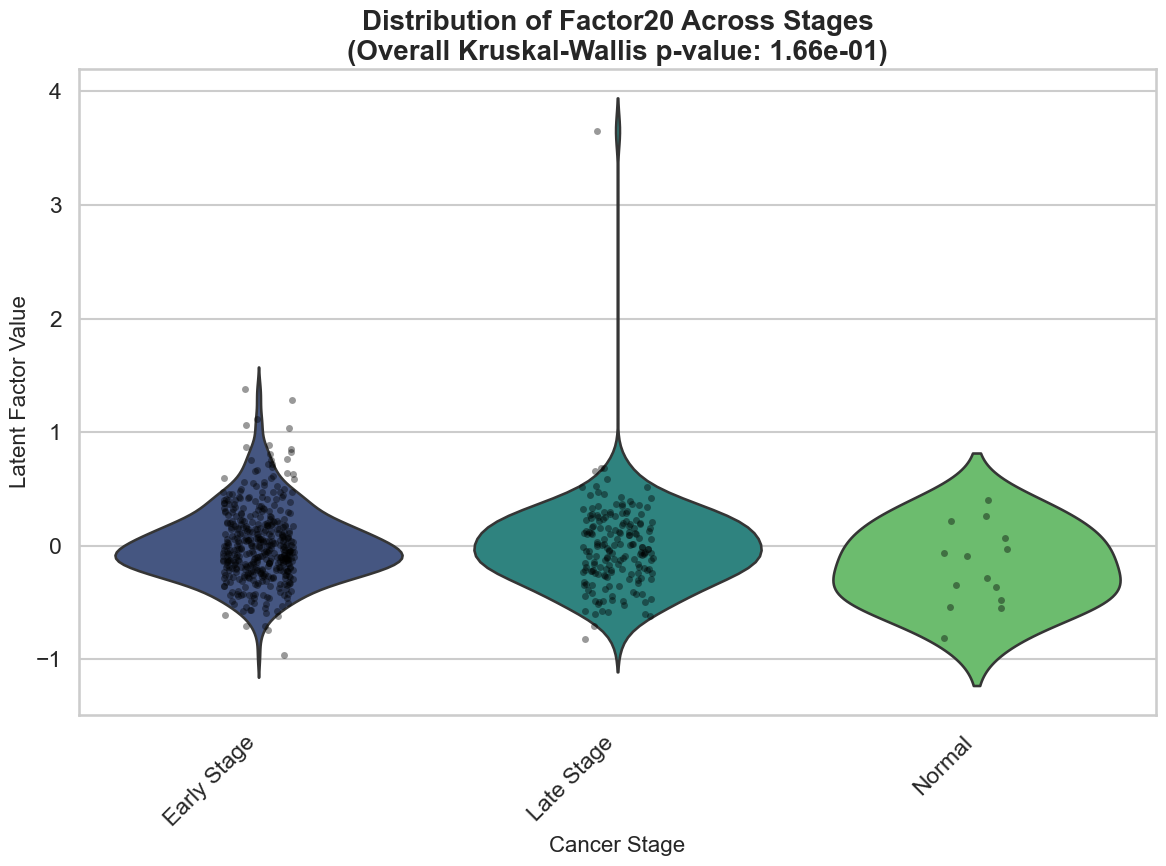


--- Analysis and Visualization Complete ---


In [28]:
print("\n--- Starting Advanced Visualization Suite ---")
# --- Define a consistent and professional plot style ---
sns.set_style("whitegrid")
sns.set_context("talk")
stage_order = sorted(latent_factors['stage_classification'].unique())
stage_palette = sns.color_palette("viridis", n_colors=len(stage_order))
stage_lut = dict(zip(stage_order, stage_palette))

# --- Data Prep for plots ---
summary_sig = pd.DataFrame(index=latent_factors_columns)
summary_sig['ANOVA'] = anova_df['p-value'] < 0.05
summary_sig['Kruskal-Wallis'] = kruskal_df['p-value'] < 0.05
summary_sig['Mann-Whitney (E vs L)'] = early_vs_late_df['p-value'] < 0.05
summary_sig['Any Welch\'s'] = summary_sig.index.isin(significant_welch_results['Factor'].unique())
summary_sig['Total Tests Passed'] = summary_sig.sum(axis=1)
summary_sig = summary_sig.sort_values('Total Tests Passed', ascending=False)
# MODIFIED: The detailed plots will now be generated for ALL factors.
# The `selected_factors` variable is now renamed to `all_factors` for clarity.
all_factors = latent_factors_columns
print(f"\nGenerating detailed plots for all {len(all_factors)} factors.")


# --- Plot 1: Multivariate Clustering Heatmap ---
print("\n--- 1. Generating Multivariate Clustering Heatmap ---")
mean_factor_values = latent_factors.groupby('stage_classification')[latent_factors_columns].mean()
sns.clustermap(mean_factor_values.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5, figsize=(15, 12), standard_scale=1)
plt.suptitle('Hierarchically Clustered Heatmap of Mean Factor Values', fontsize=20, weight='bold', y=1.02)
output_path = os.path.join(PLOTS_DIR, "summary_clustered_heatmap.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()

# --- Plot 2: Decision Justification Dot Plot ---
print("\n--- 2. Generating Decision Justification Dot Plot ---")
summary_sig_melted = summary_sig.reset_index().melt(id_vars=['index', 'Total Tests Passed'], var_name='Test', value_name='Significant')
summary_sig_melted = summary_sig_melted[summary_sig_melted['Significant']]

plt.figure(figsize=(12, 10))
sns.scatterplot(data=summary_sig_melted, y='index', x='Test', s=200, hue='Total Tests Passed', palette='viridis', legend='full')
plt.title('Factor Significance Across Multiple Statistical Tests', fontsize=20, weight='bold')
plt.ylabel('Latent Factor', fontsize=16)
plt.xlabel('Statistical Test', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
output_path = os.path.join(PLOTS_DIR, "summary_decision_dot_plot.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()

# --- Plot 3: Side-by-Side Bar Plot for ANOVA vs. Kruskal-Wallis ---
print("\n--- 3. Generating ANOVA vs. Kruskal-Wallis Significance Comparison ---")
# Prepare data for plotting
p_value_comp = pd.DataFrame({
    'ANOVA': -np.log10(anova_df['p-value']),
    'Kruskal-Wallis': -np.log10(kruskal_df['p-value'])
}).reset_index().melt(id_vars='index', var_name='Test', value_name='-log10(p-value)')
p_value_comp.rename(columns={'index': 'Factor'}, inplace=True)

plt.figure(figsize=(20, 10))
sns.barplot(data=p_value_comp, x='Factor', y='-log10(p-value)', hue='Test', palette='magma')
plt.axhline(-np.log10(0.05), color='r', linestyle='--', label='p-value = 0.05 threshold')
plt.title('Comparison of Significance from ANOVA and Kruskal-Wallis Tests', fontsize=20, weight='bold')
plt.xlabel('Latent Factor', fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Test Type')
plt.tight_layout()
output_path = os.path.join(PLOTS_DIR, "comparison_anova_vs_kruskal_pvalues.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()

# --- Plot 4: Scatterplot of ANOVA vs. Kruskal-Wallis Statistics ---
print("\n--- 4. Generating ANOVA vs. Kruskal-Wallis Statistic Comparison ---")
stats_comp = pd.DataFrame({
    'ANOVA F-value': anova_df['F-value'],
    'Kruskal-Wallis H-statistic': kruskal_df['H-statistic'],
    'KW p-value': -np.log10(kruskal_df['p-value']) # Use p-value for color
})

plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data=stats_comp, x='ANOVA F-value', y='Kruskal-Wallis H-statistic',
                     hue='KW p-value', size='KW p-value', sizes=(50, 500),
                     palette='viridis', legend='auto')

# Annotate points
for factor_name in stats_comp.index:
    plt.text(x=stats_comp.loc[factor_name, 'ANOVA F-value'] + 0.3,
             y=stats_comp.loc[factor_name, 'Kruskal-Wallis H-statistic'],
             s=factor_name, fontsize=10)

plt.title('Effect Size Comparison: ANOVA vs. Kruskal-Wallis', fontsize=20, weight='bold')
plt.xlabel('ANOVA F-value', fontsize=16)
plt.ylabel('Kruskal-Wallis H-statistic', fontsize=16)
ax.legend(title='-log10(KW p-value)')
plt.grid(True)
plt.tight_layout()
output_path = os.path.join(PLOTS_DIR, "comparison_anova_vs_kruskal_statistics.png")
plt.savefig(output_path, dpi=300)
print(f"Saved plot to {output_path}")
plt.show()

# --- Plot 5: Detailed Violin Plots with Statistical Annotations for ALL Factors ---
print("\n--- 5. Generating Detailed Plots for All Factors ---")
def p_to_stars(p):
    if p <= 0.001: return '***';
    if p <= 0.01: return '**';
    if p <= 0.05: return '*';
    return 'ns' # not significant

for factor in all_factors:
    plt.figure(figsize=(12, 9))
    
    ax = sns.violinplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order, 
                        palette='viridis', inner=None)
    sns.stripplot(data=latent_factors, x='stage_classification', y=factor, order=stage_order, 
                  color='black', jitter=0.1, alpha=0.4, ax=ax)

    kw_p_value = kruskal_df.loc[factor, 'p-value']
    plt.title(f'Distribution of {factor} Across Stages\n(Overall Kruskal-Wallis p-value: {kw_p_value:.2e})', 
              fontsize=20, weight='bold')

    y_max = latent_factors[factor].max()
    y_range = latent_factors[factor].max() - latent_factors[factor].min()
    y_step = y_range * 0.1
    y_positions_used = []

    factor_welch_sigs = significant_welch_results[significant_welch_results['Factor'] == factor]

    for _, row in factor_welch_sigs.iterrows():
        g1, g2, p = row['Group1'], row['Group2'], row['p-value']
        if g1 not in stage_order or g2 not in stage_order: continue
        x1, x2 = stage_order.index(g1), stage_order.index(g2)
        
        y = y_max + y_step
        while any(abs(y - pos) < y_step for pos in y_positions_used):
            y += y_step*0.5
        
        h = y_step * 0.5
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
        plt.text((x1+x2)*.5, y+h, p_to_stars(p), ha='center', va='bottom', color='k', fontsize=16)
        y_positions_used.append(y + h)
    
    if y_positions_used: plt.ylim(top=max(y_positions_used) + y_step)

    plt.xlabel('Cancer Stage', fontsize=16)
    plt.ylabel('Latent Factor Value', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    output_path = os.path.join(PLOTS_DIR, f"{factor}_detailed_stats_violinplot.png")
    plt.savefig(output_path, dpi=300)
    print(f"Saved plot to {output_path}")
    plt.show()

print("\n--- Analysis and Visualization Complete ---")

In [29]:
clinical_data.head()

SampleID ajcc_pathologic_stage          sample_type  \
0  TCGA-3C-AALI-01             Stage IIB  Primary solid Tumor   
1  TCGA-3C-AALK-01              Stage IA  Primary solid Tumor   
2  TCGA-4H-AAAK-01            Stage IIIA  Primary solid Tumor   
3  TCGA-5L-AAT1-01              Stage IV  Primary solid Tumor   
4  TCGA-5T-A9QA-01             Stage IIA  Primary solid Tumor   

  stage_classification  
0          Early Stage  
1          Early Stage  
2           Late Stage  
3           Late Stage  
4          Early Stage

In [30]:
sample_counts = latent_factors['stage_classification'].value_counts()
print(sample_counts)

stage_classification
Early Stage    430
Late Stage     180
Normal          14
Name: count, dtype: int64
